# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [2]:
#解决运行时 The kernel appears to have died. It will restart automatically
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import numpy as np
#%matplotlib widget
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [4]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape, "x_ideal.shape", x_ideal.shape, "y_ideal.shape", y_ideal.shape)
print (np.vstack((X, x_ideal)))
print (np.vstack((y, y_ideal)))

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,) x_ideal.shape (18,) y_ideal.shape (18,)
[[ 0.    2.88  5.76  8.65 11.53 14.41 17.29 20.18 23.06 25.94 28.82 31.71
  34.59 37.47 40.35 43.24 46.12 49.  ]
 [ 0.    2.88  5.76  8.65 11.53 14.41 17.29 20.18 23.06 25.94 28.82 31.71
  34.59 37.47 40.35 43.24 46.12 49.  ]]
[[   0.      5.55   34.39   71.39  125.52  183.03  237.25  441.08  457.14
   563.11  901.24 1025.77  890.33 1417.39 1268.67 2242.65 2653.83 2391.31]
 [   0.      8.31   33.23   74.77  132.93  207.7   299.09  407.09  531.71
   672.94  830.8  1005.26 1196.35 1404.04 1628.36 1869.29 2126.84 2401.  ]]
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

<IPython.core.display.Javascript object>


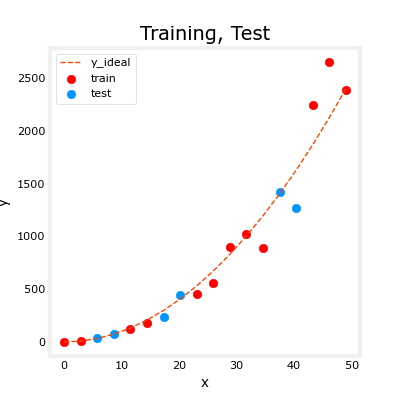

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [6]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
       err += (y[i]-yhat[i])**2
        
    err = err / (2*m)
    ### END CODE HERE ### 
    
    return(err)

In [7]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [8]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
# 使用10次函数拟合 —— 过拟合
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [9]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

(100,) (18,)


<IPython.core.display.Javascript object>


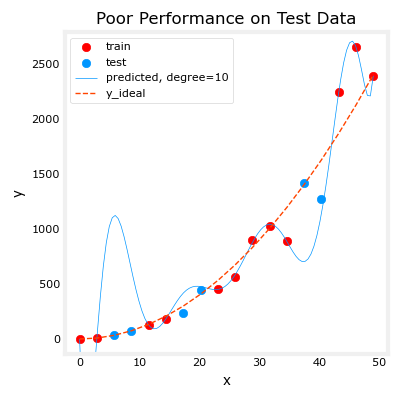

In [10]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
print (x.shape, X.shape)
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [11]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

<IPython.core.display.Javascript object>


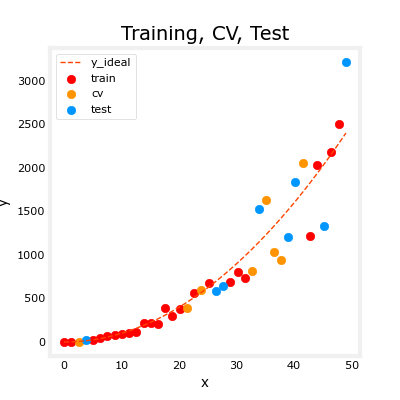

In [12]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [13]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

<IPython.core.display.Javascript object>


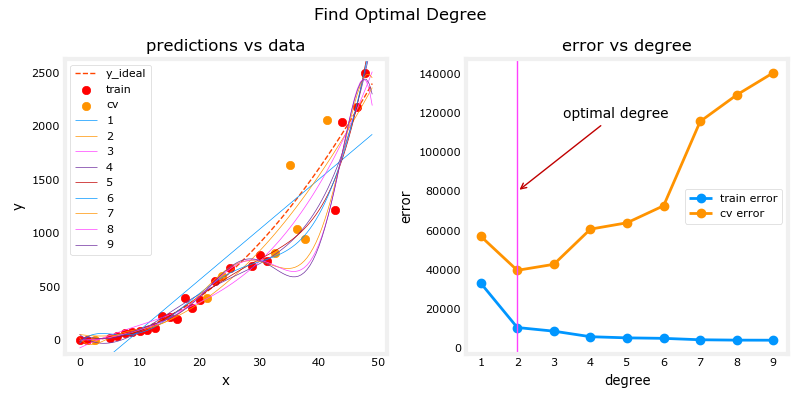

In [14]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [17]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 9
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

<IPython.core.display.Javascript object>


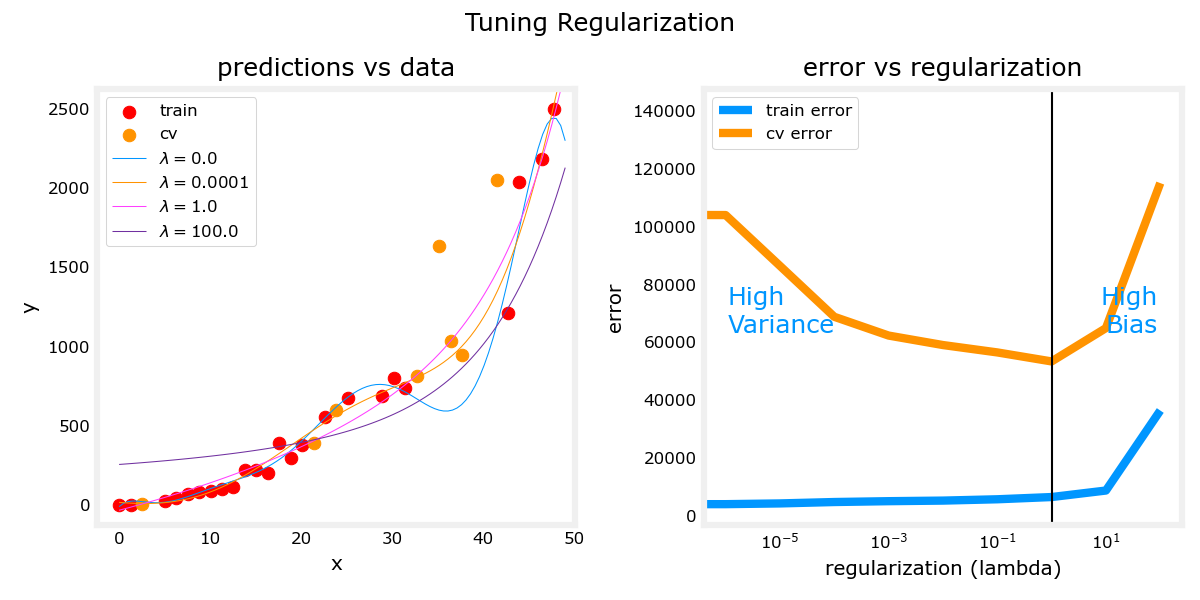

In [18]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

(450,) (450,)
(150,) (150,)
[ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]


<IPython.core.display.Javascript object>


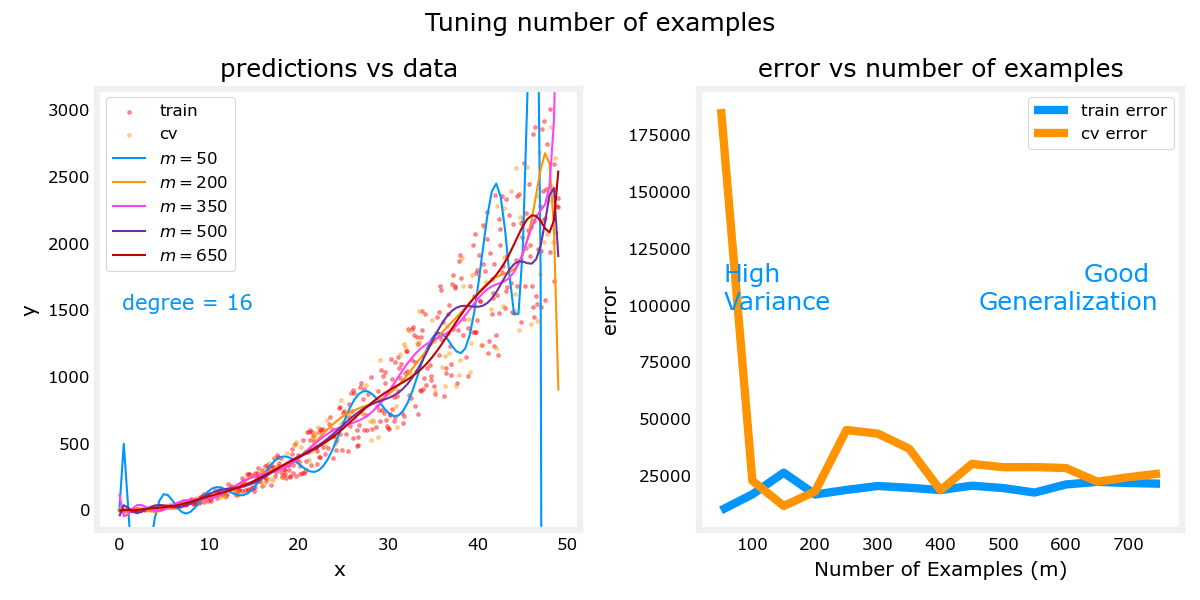

In [23]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
print (X_train.shape, y_train.shape)
print (X_cv.shape, y_cv.shape)
#print (err_train, err_cv)
print (m_range)
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [24]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


<IPython.core.display.Javascript object>


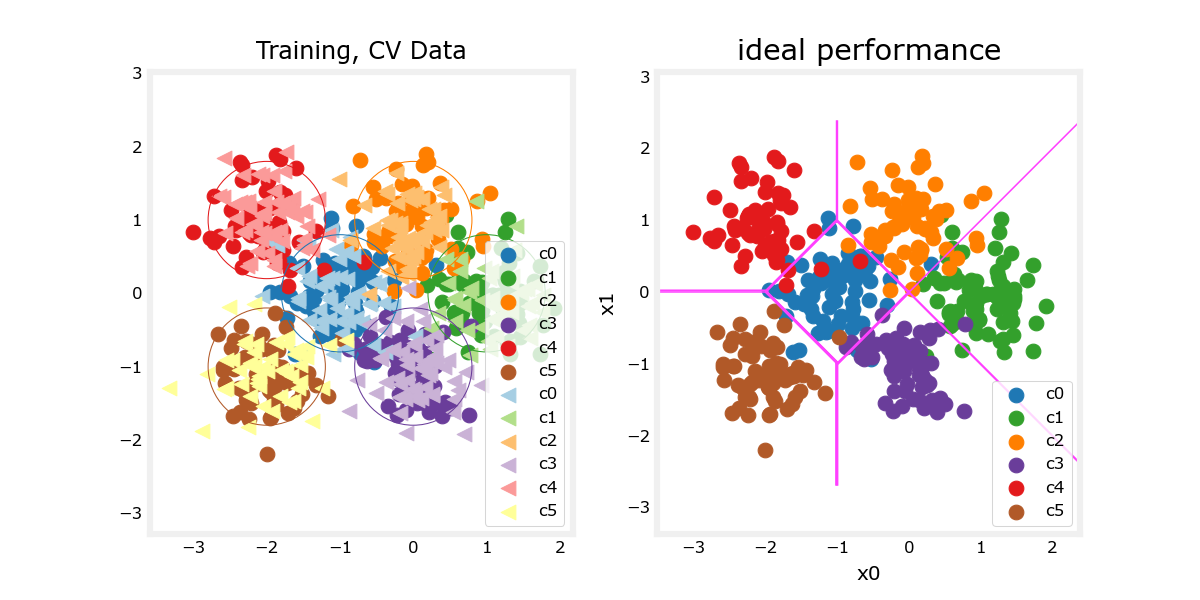

In [25]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [43]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if (y[i] != yhat[i]): incorrect +=1
    cerr = incorrect / m
    ### END CODE HERE ### 
    
    return(cerr)

In [44]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [46]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=120, activation="relu"),
        Dense(units=40, activation="relu"),
        Dense(units=6, activation="linear") 
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate =0.01),
    ### END CODE HERE ### 
)

In [47]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 855us/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 812us/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 903us/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 914us/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 925us/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 855us/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 916us/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 916us/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 942us/step - loss: 0.2070
Epo

13/13 [==============================] - 0s 1ms/step - loss: 0.1685
Epoch 100/1000
13/13 [==============================] - 0s 937us/step - loss: 0.1569
Epoch 101/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1645
Epoch 102/1000
13/13 [==============================] - 0s 973us/step - loss: 0.1737
Epoch 103/1000
13/13 [==============================] - 0s 933us/step - loss: 0.1935
Epoch 104/1000
13/13 [==============================] - 0s 960us/step - loss: 0.1600
Epoch 105/1000
13/13 [==============================] - 0s 930us/step - loss: 0.1483
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1555
Epoch 107/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1678
Epoch 108/1000
13/13 [==============================] - 0s 895us/step - loss: 0.1435
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1419
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1494
Epoch

13/13 [==============================] - 0s 871us/step - loss: 0.1006
Epoch 197/1000
13/13 [==============================] - 0s 959us/step - loss: 0.0974
Epoch 198/1000
13/13 [==============================] - 0s 910us/step - loss: 0.1141
Epoch 199/1000
13/13 [==============================] - 0s 905us/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 856us/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 933us/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 969us/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 949us/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1129
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1219
Epoch 207/1000
13/13 [==============================] - 0s 999us/step - loss: 0.11

13/13 [==============================] - 0s 930us/step - loss: 0.0848
Epoch 293/1000
13/13 [==============================] - 0s 803us/step - loss: 0.0701
Epoch 294/1000
13/13 [==============================] - 0s 938us/step - loss: 0.0828
Epoch 295/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0741
Epoch 296/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0890
Epoch 297/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0733
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0544
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 303/1000
13/13 [==============================] - 0s 984us/step - loss: 0.0877
Epoch 304/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0525
Epoch 390/1000
13/13 [==============================] - 0s 896us/step - loss: 0.0666
Epoch 391/1000
13/13 [==============================] - 0s 926us/step - loss: 0.0490
Epoch 392/1000
13/13 [==============================] - 0s 938us/step - loss: 0.0551
Epoch 393/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0689
Epoch 394/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0663
Epoch 395/1000
13/13 [==============================] - 0s 990us/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0700
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0586
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 401/1

13/13 [==============================] - 0s 956us/step - loss: 0.1045
Epoch 487/1000
13/13 [==============================] - 0s 961us/step - loss: 0.0973
Epoch 488/1000
13/13 [==============================] - 0s 876us/step - loss: 0.0763
Epoch 489/1000
13/13 [==============================] - 0s 905us/step - loss: 0.0694
Epoch 490/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0752
Epoch 491/1000
13/13 [==============================] - 0s 886us/step - loss: 0.0742
Epoch 492/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 493/1000
13/13 [==============================] - 0s 953us/step - loss: 0.0734
Epoch 494/1000
13/13 [==============================] - 0s 972us/step - loss: 0.0579
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 496/1000
13/13 [==============================] - 0s 998us/step - loss: 0.0580
Epoch 497/1000
13/13 [==============================] - 0s 938us/step - loss: 0.0463
E

13/13 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 584/1000
13/13 [==============================] - 0s 967us/step - loss: 0.0374
Epoch 585/1000
13/13 [==============================] - 0s 966us/step - loss: 0.0304
Epoch 586/1000
13/13 [==============================] - 0s 966us/step - loss: 0.0322
Epoch 587/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 588/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0279
Epoch 589/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0273
Epoch 590/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0297
Epoch 591/1000
13/13 [==============================] - 0s 921us/step - loss: 0.0393
Epoch 592/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0362
Epoch 593/1000
13/13 [==============================] - 0s 835us/step - loss: 0.0435
Epoch 594/1000
13/13 [==============================] - 0s 949us/step - loss: 0.0340
Ep

13/13 [==============================] - 0s 1ms/step - loss: 0.0353
Epoch 681/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0606
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0485
Epoch 683/1000
13/13 [==============================] - 0s 926us/step - loss: 0.0609
Epoch 684/1000
13/13 [==============================] - 0s 961us/step - loss: 0.0793
Epoch 685/1000
13/13 [==============================] - 0s 867us/step - loss: 0.0711
Epoch 686/1000
13/13 [==============================] - 0s 809us/step - loss: 0.0821
Epoch 687/1000
13/13 [==============================] - 0s 884us/step - loss: 0.0558
Epoch 688/1000
13/13 [==============================] - 0s 886us/step - loss: 0.0766
Epoch 689/1000
13/13 [==============================] - 0s 939us/step - loss: 0.0471
Epoch 690/1000
13/13 [==============================] - 0s 928us/step - loss: 0.0800
Epoch 691/1000
13/13 [==============================] - 0s 843us/step - loss: 0.0443
E

Epoch 777/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0211
Epoch 778/1000
13/13 [==============================] - 0s 965us/step - loss: 0.0222
Epoch 779/1000
13/13 [==============================] - 0s 895us/step - loss: 0.0216
Epoch 780/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0249
Epoch 781/1000
13/13 [==============================] - 0s 941us/step - loss: 0.0234
Epoch 782/1000
13/13 [==============================] - 0s 973us/step - loss: 0.0232
Epoch 783/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0202
Epoch 784/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0258
Epoch 785/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 786/1000
13/13 [==============================] - 0s 990us/step - loss: 0.0219
Epoch 787/1000
13/13 [==============================] - 0s 977us/step - loss: 0.0207
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - los

13/13 [==============================] - 0s 983us/step - loss: 0.0492
Epoch 875/1000
13/13 [==============================] - 0s 912us/step - loss: 0.1839
Epoch 876/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1089
Epoch 877/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0550
Epoch 878/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0369
Epoch 879/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0318
Epoch 880/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 881/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0312
Epoch 882/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.0311
Epoch 883/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 884/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0315
Epoch 885/1000
13/13 [==============================] - 0s 999us/step - loss: 0.0268
Epoch

13/13 [==============================] - 0s 902us/step - loss: 0.0198
Epoch 972/1000
13/13 [==============================] - 0s 986us/step - loss: 0.0182
Epoch 973/1000
13/13 [==============================] - 0s 947us/step - loss: 0.0205
Epoch 974/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0299
Epoch 975/1000
13/13 [==============================] - 0s 994us/step - loss: 0.0955
Epoch 976/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1681
Epoch 977/1000
13/13 [==============================] - 0s 937us/step - loss: 0.2642
Epoch 978/1000
13/13 [==============================] - 0s 886us/step - loss: 0.2628
Epoch 979/1000
13/13 [==============================] - 0s 831us/step - loss: 0.1767
Epoch 980/1000
13/13 [==============================] - 0s 856us/step - loss: 0.1421
Epoch 981/1000
13/13 [==============================] - 0s 952us/step - loss: 0.1784
Epoch 982/1000
13/13 [==============================] - 0s 929us/step - loss: 0.14

In [48]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 120)               360       
                                                                 
 dense_4 (Dense)             (None, 40)                4840      
                                                                 
 dense_5 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

<IPython.core.display.Javascript object>


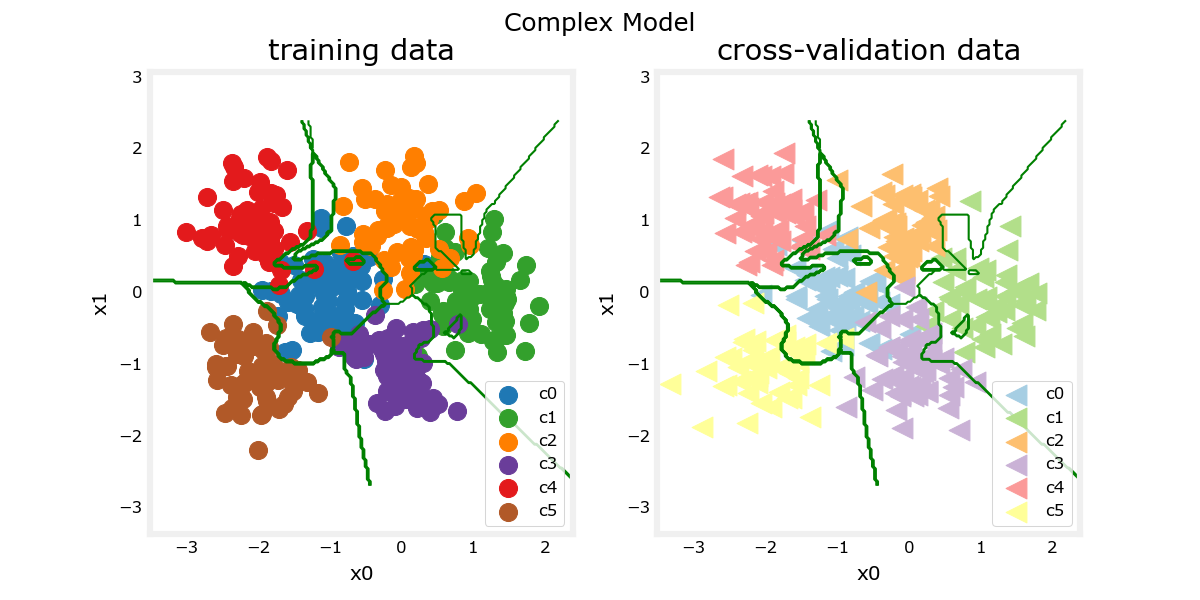

In [49]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [50]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

categorization error, training, complex model: 0.018
categorization error, cv,       complex model: 0.125


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [51]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=6, activation="relu"),
        Dense(units=6, activation="linear") 
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate =0.01),
    ### START CODE HERE ### 
)


In [52]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 706us/step - loss: 1.7306
Epoch 2/1000
13/13 [==============================] - 0s 555us/step - loss: 1.4468
Epoch 3/1000
13/13 [==============================] - 0s 714us/step - loss: 1.2902
Epoch 4/1000
13/13 [==============================] - 0s 667us/step - loss: 1.1367
Epoch 5/1000
13/13 [==============================] - 0s 687us/step - loss: 0.9710
Epoch 6/1000
13/13 [==============================] - 0s 692us/step - loss: 0.7947
Epoch 7/1000
13/13 [==============================] - 0s 563us/step - loss: 0.6499
Epoch 8/1000
13/13 [==============================] - 0s 865us/step - loss: 0.5378
Epoch 9/1000
13/13 [==============================] - 0s 798us/step - loss: 0.4652
Epoch 10/1000
13/13 [==============================] - 0s 689us/step - loss: 0.4184
Epoch 11/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3860
Epoch 12/1000
13/13 [==============================] - 0s 838us/step - loss: 0.3641
E

13/13 [==============================] - 0s 743us/step - loss: 0.2031
Epoch 99/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1991
Epoch 100/1000
13/13 [==============================] - 0s 769us/step - loss: 0.2006
Epoch 101/1000
13/13 [==============================] - 0s 789us/step - loss: 0.2010
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2018
Epoch 103/1000
13/13 [==============================] - 0s 800us/step - loss: 0.2026
Epoch 104/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1988
Epoch 105/1000
13/13 [==============================] - 0s 778us/step - loss: 0.1974
Epoch 106/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1966
Epoch 107/1000
13/13 [==============================] - 0s 754us/step - loss: 0.1963
Epoch 108/1000
13/13 [==============================] - 0s 776us/step - loss: 0.1969
Epoch 109/1000
13/13 [==============================] - 0s 704us/step - loss: 0.198

13/13 [==============================] - 0s 667us/step - loss: 0.1857
Epoch 195/1000
13/13 [==============================] - 0s 832us/step - loss: 0.1859
Epoch 196/1000
13/13 [==============================] - 0s 720us/step - loss: 0.1856
Epoch 197/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1879
Epoch 198/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1884
Epoch 199/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1894
Epoch 200/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1860
Epoch 201/1000
13/13 [==============================] - 0s 808us/step - loss: 0.1869
Epoch 202/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1837
Epoch 203/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1861
Epoch 204/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1869
Epoch 205/1000
13/13 [==============================] - 0s 750us/step - loss: 0.

13/13 [==============================] - 0s 666us/step - loss: 0.1807
Epoch 291/1000
13/13 [==============================] - 0s 749us/step - loss: 0.1801
Epoch 292/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1793
Epoch 293/1000
13/13 [==============================] - 0s 930us/step - loss: 0.1815
Epoch 294/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1784
Epoch 295/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1867
Epoch 296/1000
13/13 [==============================] - 0s 733us/step - loss: 0.1805
Epoch 297/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1855
Epoch 298/1000
13/13 [==============================] - 0s 652us/step - loss: 0.1816
Epoch 299/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1798
Epoch 300/1000
13/13 [==============================] - 0s 751us/step - loss: 0.1817
Epoch 301/1000
13/13 [==============================] - 0s 830us/step - loss: 0.18

13/13 [==============================] - 0s 667us/step - loss: 0.1781
Epoch 387/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1771
Epoch 388/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1809
Epoch 389/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1807
Epoch 390/1000
13/13 [==============================] - 0s 788us/step - loss: 0.1792
Epoch 391/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1767
Epoch 392/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1767
Epoch 393/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1763
Epoch 394/1000
13/13 [==============================] - 0s 668us/step - loss: 0.1768
Epoch 395/1000
13/13 [==============================] - 0s 998us/step - loss: 0.1789
Epoch 396/1000
13/13 [==============================] - 0s 770us/step - loss: 0.1801
Epoch 397/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 666us/step - loss: 0.1745
Epoch 483/1000
13/13 [==============================] - 0s 678us/step - loss: 0.1763
Epoch 484/1000
13/13 [==============================] - 0s 625us/step - loss: 0.1767
Epoch 485/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1780
Epoch 486/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1739
Epoch 487/1000
13/13 [==============================] - 0s 762us/step - loss: 0.1781
Epoch 488/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1755
Epoch 489/1000
13/13 [==============================] - 0s 751us/step - loss: 0.1766
Epoch 490/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1783
Epoch 491/1000
13/13 [==============================] - 0s 761us/step - loss: 0.1769
Epoch 492/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1752
Epoch 493/1000
13/13 [==============================] - 0s 583us/step - loss: 0.

13/13 [==============================] - 0s 881us/step - loss: 0.1741
Epoch 579/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1732
Epoch 580/1000
13/13 [==============================] - 0s 678us/step - loss: 0.1725
Epoch 581/1000
13/13 [==============================] - 0s 802us/step - loss: 0.1731
Epoch 582/1000
13/13 [==============================] - 0s 952us/step - loss: 0.1709
Epoch 583/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1727
Epoch 584/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1742
Epoch 585/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1721
Epoch 586/1000
13/13 [==============================] - 0s 765us/step - loss: 0.1730
Epoch 587/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1728
Epoch 588/1000
13/13 [==============================] - 0s 749us/step - loss: 0.1718
Epoch 589/1000
13/13 [==============================] - 0s 728us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.1740
Epoch 675/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1699
Epoch 676/1000
13/13 [==============================] - 0s 668us/step - loss: 0.1712
Epoch 677/1000
13/13 [==============================] - 0s 677us/step - loss: 0.1711
Epoch 678/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1718
Epoch 679/1000
13/13 [==============================] - 0s 595us/step - loss: 0.1795
Epoch 680/1000
13/13 [==============================] - 0s 638us/step - loss: 0.1709
Epoch 681/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1703
Epoch 682/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1717
Epoch 683/1000
13/13 [==============================] - 0s 717us/step - loss: 0.1758
Epoch 684/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1699
Epoch 685/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 750us/step - loss: 0.1693
Epoch 771/1000
13/13 [==============================] - 0s 664us/step - loss: 0.1708
Epoch 772/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1693
Epoch 773/1000
13/13 [==============================] - 0s 623us/step - loss: 0.1697
Epoch 774/1000
13/13 [==============================] - 0s 622us/step - loss: 0.1712
Epoch 775/1000
13/13 [==============================] - 0s 788us/step - loss: 0.1704
Epoch 776/1000
13/13 [==============================] - 0s 776us/step - loss: 0.1681
Epoch 777/1000
13/13 [==============================] - 0s 760us/step - loss: 0.1704
Epoch 778/1000
13/13 [==============================] - 0s 770us/step - loss: 0.1721
Epoch 779/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1706
Epoch 780/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1747
Epoch 781/1000
13/13 [==============================] - 0s 584us/step - loss: 0.

13/13 [==============================] - 0s 781us/step - loss: 0.1702
Epoch 867/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1695
Epoch 868/1000
13/13 [==============================] - 0s 776us/step - loss: 0.1728
Epoch 869/1000
13/13 [==============================] - 0s 711us/step - loss: 0.1682
Epoch 870/1000
13/13 [==============================] - 0s 698us/step - loss: 0.1681
Epoch 871/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1684
Epoch 872/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1680
Epoch 873/1000
13/13 [==============================] - 0s 588us/step - loss: 0.1720
Epoch 874/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1705
Epoch 875/1000
13/13 [==============================] - 0s 730us/step - loss: 0.1686
Epoch 876/1000
13/13 [==============================] - 0s 591us/step - loss: 0.1676
Epoch 877/1000
13/13 [==============================] - 0s 750us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.1667
Epoch 963/1000
13/13 [==============================] - 0s 749us/step - loss: 0.1757
Epoch 964/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1661
Epoch 965/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1713
Epoch 966/1000
13/13 [==============================] - 0s 696us/step - loss: 0.1671
Epoch 967/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1697
Epoch 968/1000
13/13 [==============================] - 0s 665us/step - loss: 0.1716
Epoch 969/1000
13/13 [==============================] - 0s 717us/step - loss: 0.1688
Epoch 970/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1672
Epoch 971/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1664
Epoch 972/1000
13/13 [==============================] - 0s 751us/step - loss: 0.1684
Epoch 973/1000
13/13 [==============================] - 0s 584us/step - loss: 0.

In [53]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 18        
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

<IPython.core.display.Javascript object>


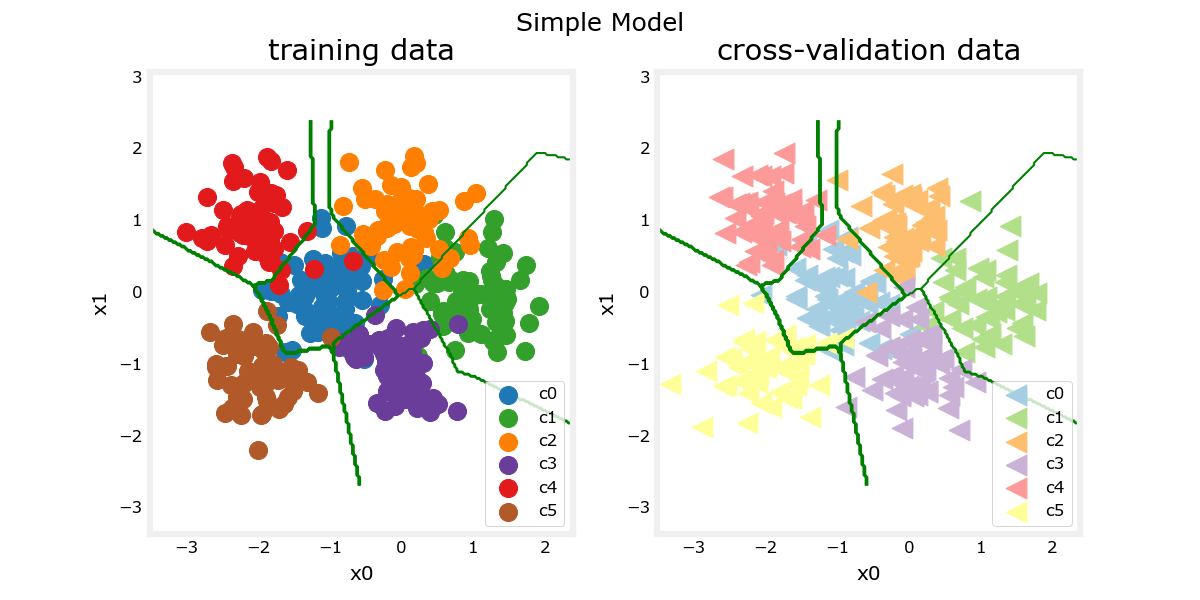

In [55]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [56]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, simple model, 0.062, complex model: 0.018
categorization error, cv,       simple model, 0.087, complex model: 0.125


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [57]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(units=120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=6, activation="linear")         
        
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate =0.01),
    ### START CODE HERE ### 
)


In [58]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 4.4464
Epoch 2/1000
13/13 [==============================] - 0s 942us/step - loss: 1.7086
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.3465
Epoch 4/1000
13/13 [==============================] - 0s 957us/step - loss: 1.0870
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0137
Epoch 6/1000
13/13 [==============================] - 0s 904us/step - loss: 0.9718
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9481
Epoch 8/1000
13/13 [==============================] - 0s 996us/step - loss: 0.8934
Epoch 9/1000
13/13 [==============================] - 0s 885us/step - loss: 0.8171
Epoch 10/1000
13/13 [==============================] - 0s 927us/step - loss: 0.7715
Epoch 11/1000
13/13 [==============================] - 0s 952us/step - loss: 0.7611
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7521
Epoch 13/10

13/13 [==============================] - 0s 956us/step - loss: 0.4961
Epoch 100/1000
13/13 [==============================] - 0s 963us/step - loss: 0.4954
Epoch 101/1000
13/13 [==============================] - 0s 979us/step - loss: 0.4874
Epoch 102/1000
13/13 [==============================] - 0s 856us/step - loss: 0.4759
Epoch 103/1000
13/13 [==============================] - 0s 834us/step - loss: 0.4739
Epoch 104/1000
13/13 [==============================] - 0s 910us/step - loss: 0.4682
Epoch 105/1000
13/13 [==============================] - 0s 948us/step - loss: 0.5125
Epoch 106/1000
13/13 [==============================] - 0s 920us/step - loss: 0.4548
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4610
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4702
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4565
Epoch 110/1000
13/13 [==============================] - 0s 866us/step - loss: 0.4568
E

13/13 [==============================] - 0s 952us/step - loss: 0.4026
Epoch 196/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3953
Epoch 197/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4191
Epoch 198/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3963
Epoch 199/1000
13/13 [==============================] - 0s 921us/step - loss: 0.4080
Epoch 200/1000
13/13 [==============================] - 0s 855us/step - loss: 0.4032
Epoch 201/1000
13/13 [==============================] - 0s 916us/step - loss: 0.4268
Epoch 202/1000
13/13 [==============================] - 0s 965us/step - loss: 0.3954
Epoch 203/1000
13/13 [==============================] - 0s 933us/step - loss: 0.3980
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4088
Epoch 205/1000
13/13 [==============================] - 0s 802us/step - loss: 0.4571
Epoch 206/1000
13/13 [==============================] - 0s 866us/step - loss: 0.4315
Epo

Epoch 292/1000
13/13 [==============================] - 0s 918us/step - loss: 0.3697
Epoch 293/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3800
Epoch 294/1000
13/13 [==============================] - 0s 956us/step - loss: 0.4007
Epoch 295/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4066
Epoch 296/1000
13/13 [==============================] - 0s 974us/step - loss: 0.3768
Epoch 297/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3841
Epoch 298/1000
13/13 [==============================] - 0s 871us/step - loss: 0.3884
Epoch 299/1000
13/13 [==============================] - 0s 918us/step - loss: 0.3926
Epoch 300/1000
13/13 [==============================] - 0s 964us/step - loss: 0.4250
Epoch 301/1000
13/13 [==============================] - 0s 864us/step - loss: 0.3915
Epoch 302/1000
13/13 [==============================] - 0s 843us/step - loss: 0.3894
Epoch 303/1000
13/13 [==============================] - 0s 916us/step -

13/13 [==============================] - 0s 1ms/step - loss: 0.3674
Epoch 390/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3531
Epoch 391/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3664
Epoch 392/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3819
Epoch 393/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3605
Epoch 394/1000
13/13 [==============================] - 0s 952us/step - loss: 0.3635
Epoch 395/1000
13/13 [==============================] - 0s 906us/step - loss: 0.3932
Epoch 396/1000
13/13 [==============================] - 0s 901us/step - loss: 0.3799
Epoch 397/1000
13/13 [==============================] - 0s 927us/step - loss: 0.3915
Epoch 398/1000
13/13 [==============================] - 0s 980us/step - loss: 0.3771
Epoch 399/1000
13/13 [==============================] - 0s 931us/step - loss: 0.3753
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3727
Epoch 4

13/13 [==============================] - 0s 869us/step - loss: 0.3564
Epoch 487/1000
13/13 [==============================] - 0s 989us/step - loss: 0.3470
Epoch 488/1000
13/13 [==============================] - 0s 899us/step - loss: 0.3539
Epoch 489/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3401
Epoch 490/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3561
Epoch 491/1000
13/13 [==============================] - 0s 955us/step - loss: 0.3693
Epoch 492/1000
13/13 [==============================] - 0s 939us/step - loss: 0.3690
Epoch 493/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3510
Epoch 494/1000
13/13 [==============================] - 0s 872us/step - loss: 0.3548
Epoch 495/1000
13/13 [==============================] - 0s 893us/step - loss: 0.3525
Epoch 496/1000
13/13 [==============================] - 0s 965us/step - loss: 0.3736
Epoch 497/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4008


13/13 [==============================] - 0s 1ms/step - loss: 0.3571
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3818
Epoch 585/1000
13/13 [==============================] - 0s 936us/step - loss: 0.3954
Epoch 586/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3669
Epoch 587/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3536
Epoch 588/1000
13/13 [==============================] - 0s 915us/step - loss: 0.3407
Epoch 589/1000
13/13 [==============================] - 0s 862us/step - loss: 0.3348
Epoch 590/1000
13/13 [==============================] - 0s 920us/step - loss: 0.3374
Epoch 591/1000
13/13 [==============================] - 0s 882us/step - loss: 0.3489
Epoch 592/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3452
Epoch 593/1000
13/13 [==============================] - 0s 916us/step - loss: 0.3429
Epoch 594/1000
13/13 [==============================] - 0s 963us/step - loss: 0.3425
Epo

13/13 [==============================] - 0s 914us/step - loss: 0.3406
Epoch 681/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3549
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3399
Epoch 683/1000
13/13 [==============================] - 0s 860us/step - loss: 0.3363
Epoch 684/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3415
Epoch 685/1000
13/13 [==============================] - 0s 898us/step - loss: 0.3470
Epoch 686/1000
13/13 [==============================] - 0s 834us/step - loss: 0.3487
Epoch 687/1000
13/13 [==============================] - 0s 914us/step - loss: 0.3424
Epoch 688/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3321
Epoch 689/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3976
Epoch 690/1000
13/13 [==============================] - 0s 961us/step - loss: 0.3724
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3471
E

13/13 [==============================] - 0s 881us/step - loss: 0.3705
Epoch 778/1000
13/13 [==============================] - 0s 917us/step - loss: 0.3279
Epoch 779/1000
13/13 [==============================] - 0s 986us/step - loss: 0.3339
Epoch 780/1000
13/13 [==============================] - 0s 966us/step - loss: 0.3435
Epoch 781/1000
13/13 [==============================] - 0s 948us/step - loss: 0.3393
Epoch 782/1000
13/13 [==============================] - 0s 888us/step - loss: 0.3259
Epoch 783/1000
13/13 [==============================] - 0s 887us/step - loss: 0.3296
Epoch 784/1000
13/13 [==============================] - 0s 788us/step - loss: 0.3298
Epoch 785/1000
13/13 [==============================] - 0s 937us/step - loss: 0.3286
Epoch 786/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3392
Epoch 787/1000
13/13 [==============================] - 0s 949us/step - loss: 0.3368
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3307

Epoch 874/1000
13/13 [==============================] - 0s 881us/step - loss: 0.3479
Epoch 875/1000
13/13 [==============================] - 0s 894us/step - loss: 0.3524
Epoch 876/1000
13/13 [==============================] - 0s 953us/step - loss: 0.3360
Epoch 877/1000
13/13 [==============================] - 0s 891us/step - loss: 0.3316
Epoch 878/1000
13/13 [==============================] - 0s 846us/step - loss: 0.3564
Epoch 879/1000
13/13 [==============================] - 0s 804us/step - loss: 0.3425
Epoch 880/1000
13/13 [==============================] - 0s 829us/step - loss: 0.3270
Epoch 881/1000
13/13 [==============================] - 0s 894us/step - loss: 0.3594
Epoch 882/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3598
Epoch 883/1000
13/13 [==============================] - 0s 984us/step - loss: 0.4354
Epoch 884/1000
13/13 [==============================] - 0s 944us/step - loss: 0.3778
Epoch 885/1000
13/13 [==============================] - 0s 930us/st

13/13 [==============================] - 0s 834us/step - loss: 0.3494
Epoch 972/1000
13/13 [==============================] - 0s 951us/step - loss: 0.3260
Epoch 973/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3279
Epoch 974/1000
13/13 [==============================] - 0s 980us/step - loss: 0.3238
Epoch 975/1000
13/13 [==============================] - 0s 936us/step - loss: 0.3419
Epoch 976/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3488
Epoch 977/1000
13/13 [==============================] - 0s 929us/step - loss: 0.3278
Epoch 978/1000
13/13 [==============================] - 0s 857us/step - loss: 0.3219
Epoch 979/1000
13/13 [==============================] - 0s 922us/step - loss: 0.3267
Epoch 980/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3458
Epoch 981/1000
13/13 [==============================] - 0s 822us/step - loss: 0.3263
Epoch 982/1000
13/13 [==============================] - 0s 874us/step - loss: 0.3288
E

In [59]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               360       
                                                                 
 dense_9 (Dense)             (None, 40)                4840      
                                                                 
 dense_10 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

<IPython.core.display.Javascript object>


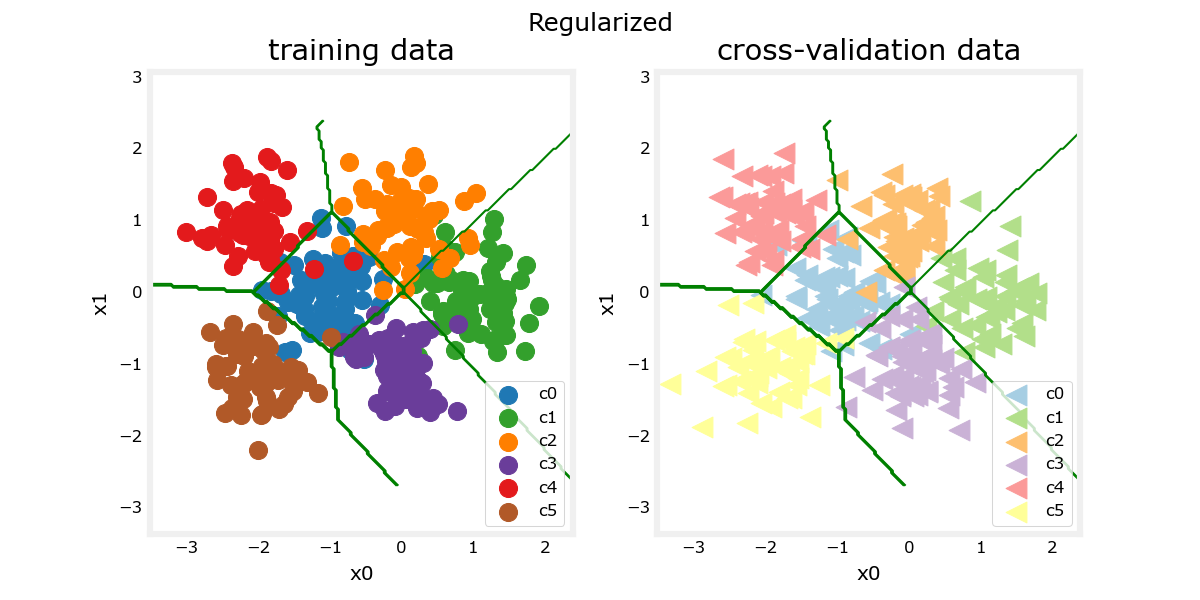

In [60]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [61]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

categorization error, training, regularized: 0.072, simple model, 0.062, complex model: 0.018
categorization error, cv,       regularized: 0.066, simple model, 0.087, complex model: 0.125


The simple model is a bit better in the training set than the regularized model but worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [62]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 917us/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 979us/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 882us/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 876us/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 809us/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 935us/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 916us/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 957us/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 918us/step - loss: 0.2070
Epoch 1

13/13 [==============================] - 0s 802us/step - loss: 0.1855
Epoch 99/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1685
Epoch 100/1000
13/13 [==============================] - 0s 883us/step - loss: 0.1569
Epoch 101/1000
13/13 [==============================] - 0s 886us/step - loss: 0.1645
Epoch 102/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1737
Epoch 103/1000
13/13 [==============================] - 0s 881us/step - loss: 0.1935
Epoch 104/1000
13/13 [==============================] - 0s 809us/step - loss: 0.1600
Epoch 105/1000
13/13 [==============================] - 0s 900us/step - loss: 0.1483
Epoch 106/1000
13/13 [==============================] - 0s 889us/step - loss: 0.1555
Epoch 107/1000
13/13 [==============================] - 0s 834us/step - loss: 0.1678
Epoch 108/1000
13/13 [==============================] - 0s 859us/step - loss: 0.1435
Epoch 109/1000
13/13 [==============================] - 0s 857us/step - loss: 0.1

13/13 [==============================] - 0s 845us/step - loss: 0.0890
Epoch 195/1000
13/13 [==============================] - 0s 928us/step - loss: 0.0880
Epoch 196/1000
13/13 [==============================] - 0s 869us/step - loss: 0.1006
Epoch 197/1000
13/13 [==============================] - 0s 838us/step - loss: 0.0974
Epoch 198/1000
13/13 [==============================] - 0s 843us/step - loss: 0.1141
Epoch 199/1000
13/13 [==============================] - 0s 842us/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 719us/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 851us/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 924us/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 991us/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 885us/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 833us/step - loss: 0.

13/13 [==============================] - 0s 896us/step - loss: 0.0682
Epoch 291/1000
13/13 [==============================] - 0s 852us/step - loss: 0.0745
Epoch 292/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0848
Epoch 293/1000
13/13 [==============================] - 0s 895us/step - loss: 0.0701
Epoch 294/1000
13/13 [==============================] - 0s 941us/step - loss: 0.0828
Epoch 295/1000
13/13 [==============================] - 0s 833us/step - loss: 0.0741
Epoch 296/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0890
Epoch 297/1000
13/13 [==============================] - 0s 782us/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 851us/step - loss: 0.0803
Epoch 299/1000
13/13 [==============================] - 0s 833us/step - loss: 0.0765
Epoch 300/1000
13/13 [==============================] - 0s 910us/step - loss: 0.0733
Epoch 301/1000
13/13 [==============================] - 0s 884us/step - loss: 0.05

13/13 [==============================] - 0s 934us/step - loss: 0.0391
Epoch 387/1000
13/13 [==============================] - 0s 828us/step - loss: 0.0394
Epoch 388/1000
13/13 [==============================] - 0s 859us/step - loss: 0.0510
Epoch 389/1000
13/13 [==============================] - 0s 801us/step - loss: 0.0525
Epoch 390/1000
13/13 [==============================] - 0s 846us/step - loss: 0.0666
Epoch 391/1000
13/13 [==============================] - 0s 783us/step - loss: 0.0490
Epoch 392/1000
13/13 [==============================] - 0s 798us/step - loss: 0.0551
Epoch 393/1000
13/13 [==============================] - 0s 888us/step - loss: 0.0689
Epoch 394/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0663
Epoch 395/1000
13/13 [==============================] - 0s 890us/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 909us/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 896us/step - loss: 0.07

13/13 [==============================] - 0s 925us/step - loss: 0.1244
Epoch 483/1000
13/13 [==============================] - 0s 926us/step - loss: 0.2012
Epoch 484/1000
13/13 [==============================] - 0s 863us/step - loss: 0.1340
Epoch 485/1000
13/13 [==============================] - 0s 866us/step - loss: 0.1073
Epoch 486/1000
13/13 [==============================] - 0s 903us/step - loss: 0.1045
Epoch 487/1000
13/13 [==============================] - 0s 947us/step - loss: 0.0973
Epoch 488/1000
13/13 [==============================] - 0s 918us/step - loss: 0.0763
Epoch 489/1000
13/13 [==============================] - 0s 906us/step - loss: 0.0694
Epoch 490/1000
13/13 [==============================] - 0s 917us/step - loss: 0.0752
Epoch 491/1000
13/13 [==============================] - 0s 817us/step - loss: 0.0742
Epoch 492/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0639
Epoch 493/1000
13/13 [==============================] - 0s 939us/step - loss: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.0405
Epoch 579/1000
13/13 [==============================] - 0s 876us/step - loss: 0.0327
Epoch 580/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0351
Epoch 581/1000
13/13 [==============================] - 0s 859us/step - loss: 0.0300
Epoch 582/1000
13/13 [==============================] - 0s 919us/step - loss: 0.0283
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0333
Epoch 584/1000
13/13 [==============================] - 0s 893us/step - loss: 0.0374
Epoch 585/1000
13/13 [==============================] - 0s 893us/step - loss: 0.0304
Epoch 586/1000
13/13 [==============================] - 0s 931us/step - loss: 0.0322
Epoch 587/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 588/1000
13/13 [==============================] - 0s 911us/step - loss: 0.0279
Epoch 589/1000
13/13 [==============================] - 0s 861us/step - loss: 0.0273
Epo

13/13 [==============================] - 0s 957us/step - loss: 0.0285
Epoch 675/1000
13/13 [==============================] - 0s 872us/step - loss: 0.0281
Epoch 676/1000
13/13 [==============================] - 0s 775us/step - loss: 0.0304
Epoch 677/1000
13/13 [==============================] - 0s 833us/step - loss: 0.0283
Epoch 678/1000
13/13 [==============================] - 0s 954us/step - loss: 0.0283
Epoch 679/1000
13/13 [==============================] - 0s 924us/step - loss: 0.0271
Epoch 680/1000
13/13 [==============================] - 0s 883us/step - loss: 0.0353
Epoch 681/1000
13/13 [==============================] - 0s 916us/step - loss: 0.0606
Epoch 682/1000
13/13 [==============================] - 0s 833us/step - loss: 0.0485
Epoch 683/1000
13/13 [==============================] - 0s 863us/step - loss: 0.0609
Epoch 684/1000
13/13 [==============================] - 0s 903us/step - loss: 0.0793
Epoch 685/1000
13/13 [==============================] - 0s 836us/step - loss: 0.

13/13 [==============================] - 0s 836us/step - loss: 0.0356
Epoch 771/1000
13/13 [==============================] - 0s 799us/step - loss: 0.0281
Epoch 772/1000
13/13 [==============================] - 0s 861us/step - loss: 0.0302
Epoch 773/1000
13/13 [==============================] - 0s 825us/step - loss: 0.0332
Epoch 774/1000
13/13 [==============================] - 0s 826us/step - loss: 0.0302
Epoch 775/1000
13/13 [==============================] - 0s 834us/step - loss: 0.0250
Epoch 776/1000
13/13 [==============================] - 0s 937us/step - loss: 0.0232
Epoch 777/1000
13/13 [==============================] - 0s 802us/step - loss: 0.0211
Epoch 778/1000
13/13 [==============================] - 0s 735us/step - loss: 0.0222
Epoch 779/1000
13/13 [==============================] - 0s 791us/step - loss: 0.0216
Epoch 780/1000
13/13 [==============================] - 0s 831us/step - loss: 0.0249
Epoch 781/1000
13/13 [==============================] - 0s 953us/step - loss: 0.

13/13 [==============================] - 0s 841us/step - loss: 0.0311
Epoch 867/1000
13/13 [==============================] - 0s 826us/step - loss: 0.0315
Epoch 868/1000
13/13 [==============================] - 0s 876us/step - loss: 0.0328
Epoch 869/1000
13/13 [==============================] - 0s 796us/step - loss: 0.0313
Epoch 870/1000
13/13 [==============================] - 0s 807us/step - loss: 0.0497
Epoch 871/1000
13/13 [==============================] - 0s 834us/step - loss: 0.0437
Epoch 872/1000
13/13 [==============================] - 0s 883us/step - loss: 0.0346
Epoch 873/1000
13/13 [==============================] - 0s 837us/step - loss: 0.0349
Epoch 874/1000
13/13 [==============================] - 0s 829us/step - loss: 0.0492
Epoch 875/1000
13/13 [==============================] - 0s 858us/step - loss: 0.1839
Epoch 876/1000
13/13 [==============================] - 0s 863us/step - loss: 0.1089
Epoch 877/1000
13/13 [==============================] - 0s 826us/step - loss: 0.

13/13 [==============================] - 0s 768us/step - loss: 0.0232
Epoch 963/1000
13/13 [==============================] - 0s 980us/step - loss: 0.0262
Epoch 964/1000
13/13 [==============================] - 0s 950us/step - loss: 0.0349
Epoch 965/1000
13/13 [==============================] - 0s 933us/step - loss: 0.0238
Epoch 966/1000
13/13 [==============================] - 0s 829us/step - loss: 0.0215
Epoch 967/1000
13/13 [==============================] - 0s 797us/step - loss: 0.0229
Epoch 968/1000
13/13 [==============================] - 0s 751us/step - loss: 0.0211
Epoch 969/1000
13/13 [==============================] - 0s 885us/step - loss: 0.0214
Epoch 970/1000
13/13 [==============================] - 0s 886us/step - loss: 0.0201
Epoch 971/1000
13/13 [==============================] - 0s 915us/step - loss: 0.0198
Epoch 972/1000
13/13 [==============================] - 0s 843us/step - loss: 0.0182
Epoch 973/1000
13/13 [==============================] - 0s 811us/step - loss: 0.

13/13 [==============================] - 0s 937us/step - loss: 0.2588
Epoch 60/1000
13/13 [==============================] - 0s 835us/step - loss: 0.2569
Epoch 61/1000
13/13 [==============================] - 0s 813us/step - loss: 0.2475
Epoch 62/1000
13/13 [==============================] - 0s 952us/step - loss: 0.2257
Epoch 63/1000
13/13 [==============================] - 0s 873us/step - loss: 0.2267
Epoch 64/1000
13/13 [==============================] - 0s 969us/step - loss: 0.2697
Epoch 65/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2643
Epoch 66/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2571
Epoch 67/1000
13/13 [==============================] - 0s 975us/step - loss: 0.2815
Epoch 68/1000
13/13 [==============================] - 0s 917us/step - loss: 0.2878
Epoch 69/1000
13/13 [==============================] - 0s 848us/step - loss: 0.2394
Epoch 70/1000
13/13 [==============================] - 0s 885us/step - loss: 0.2338
Epoch 71/1

13/13 [==============================] - 0s 926us/step - loss: 0.2131
Epoch 157/1000
13/13 [==============================] - 0s 881us/step - loss: 0.2189
Epoch 158/1000
13/13 [==============================] - 0s 934us/step - loss: 0.2196
Epoch 159/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2014
Epoch 160/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2044
Epoch 161/1000
13/13 [==============================] - 0s 867us/step - loss: 0.2024
Epoch 162/1000
13/13 [==============================] - 0s 849us/step - loss: 0.2071
Epoch 163/1000
13/13 [==============================] - 0s 763us/step - loss: 0.2171
Epoch 164/1000
13/13 [==============================] - 0s 762us/step - loss: 0.2202
Epoch 165/1000
13/13 [==============================] - 0s 816us/step - loss: 0.2135
Epoch 166/1000
13/13 [==============================] - 0s 796us/step - loss: 0.2072
Epoch 167/1000
13/13 [==============================] - 0s 797us/step - loss: 0.

13/13 [==============================] - 0s 950us/step - loss: 0.1904
Epoch 253/1000
13/13 [==============================] - 0s 844us/step - loss: 0.1942
Epoch 254/1000
13/13 [==============================] - 0s 841us/step - loss: 0.2016
Epoch 255/1000
13/13 [==============================] - 0s 930us/step - loss: 0.1996
Epoch 256/1000
13/13 [==============================] - 0s 835us/step - loss: 0.1887
Epoch 257/1000
13/13 [==============================] - 0s 790us/step - loss: 0.2110
Epoch 258/1000
13/13 [==============================] - 0s 826us/step - loss: 0.2040
Epoch 259/1000
13/13 [==============================] - 0s 961us/step - loss: 0.1890
Epoch 260/1000
13/13 [==============================] - 0s 937us/step - loss: 0.1960
Epoch 261/1000
13/13 [==============================] - 0s 883us/step - loss: 0.2038
Epoch 262/1000
13/13 [==============================] - 0s 809us/step - loss: 0.1948
Epoch 263/1000
13/13 [==============================] - 0s 829us/step - loss: 0.

13/13 [==============================] - 0s 774us/step - loss: 0.1930
Epoch 349/1000
13/13 [==============================] - 0s 818us/step - loss: 0.1804
Epoch 350/1000
13/13 [==============================] - 0s 787us/step - loss: 0.1765
Epoch 351/1000
13/13 [==============================] - 0s 878us/step - loss: 0.1839
Epoch 352/1000
13/13 [==============================] - 0s 793us/step - loss: 0.1919
Epoch 353/1000
13/13 [==============================] - 0s 883us/step - loss: 0.1982
Epoch 354/1000
13/13 [==============================] - 0s 855us/step - loss: 0.1934
Epoch 355/1000
13/13 [==============================] - 0s 812us/step - loss: 0.1957
Epoch 356/1000
13/13 [==============================] - 0s 873us/step - loss: 0.1822
Epoch 357/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1815
Epoch 358/1000
13/13 [==============================] - 0s 877us/step - loss: 0.1859
Epoch 359/1000
13/13 [==============================] - 0s 792us/step - loss: 0.

13/13 [==============================] - 0s 790us/step - loss: 0.1697
Epoch 445/1000
13/13 [==============================] - 0s 917us/step - loss: 0.1742
Epoch 446/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1905
Epoch 447/1000
13/13 [==============================] - 0s 874us/step - loss: 0.1883
Epoch 448/1000
13/13 [==============================] - 0s 922us/step - loss: 0.1722
Epoch 449/1000
13/13 [==============================] - 0s 886us/step - loss: 0.1719
Epoch 450/1000
13/13 [==============================] - 0s 873us/step - loss: 0.1731
Epoch 451/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1819
Epoch 452/1000
13/13 [==============================] - 0s 858us/step - loss: 0.1721
Epoch 453/1000
13/13 [==============================] - 0s 831us/step - loss: 0.1752
Epoch 454/1000
13/13 [==============================] - 0s 799us/step - loss: 0.1742
Epoch 455/1000
13/13 [==============================] - 0s 848us/step - loss: 0.

13/13 [==============================] - 0s 986us/step - loss: 0.1730
Epoch 541/1000
13/13 [==============================] - 0s 882us/step - loss: 0.1869
Epoch 542/1000
13/13 [==============================] - 0s 808us/step - loss: 0.1679
Epoch 543/1000
13/13 [==============================] - 0s 934us/step - loss: 0.1635
Epoch 544/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1683
Epoch 545/1000
13/13 [==============================] - 0s 914us/step - loss: 0.1704
Epoch 546/1000
13/13 [==============================] - 0s 963us/step - loss: 0.1692
Epoch 547/1000
13/13 [==============================] - 0s 827us/step - loss: 0.1742
Epoch 548/1000
13/13 [==============================] - 0s 871us/step - loss: 0.1743
Epoch 549/1000
13/13 [==============================] - 0s 798us/step - loss: 0.1815
Epoch 550/1000
13/13 [==============================] - 0s 810us/step - loss: 0.1871
Epoch 551/1000
13/13 [==============================] - 0s 902us/step - loss: 0.18

13/13 [==============================] - 0s 951us/step - loss: 0.1724
Epoch 637/1000
13/13 [==============================] - 0s 912us/step - loss: 0.1782
Epoch 638/1000
13/13 [==============================] - 0s 793us/step - loss: 0.1818
Epoch 639/1000
13/13 [==============================] - 0s 843us/step - loss: 0.1664
Epoch 640/1000
13/13 [==============================] - 0s 779us/step - loss: 0.1669
Epoch 641/1000
13/13 [==============================] - 0s 845us/step - loss: 0.1659
Epoch 642/1000
13/13 [==============================] - 0s 920us/step - loss: 0.1644
Epoch 643/1000
13/13 [==============================] - 0s 883us/step - loss: 0.1588
Epoch 644/1000
13/13 [==============================] - 0s 945us/step - loss: 0.1608
Epoch 645/1000
13/13 [==============================] - 0s 911us/step - loss: 0.1689
Epoch 646/1000
13/13 [==============================] - 0s 939us/step - loss: 0.1672
Epoch 647/1000
13/13 [==============================] - 0s 909us/step - loss: 0.

13/13 [==============================] - 0s 961us/step - loss: 0.1630
Epoch 734/1000
13/13 [==============================] - 0s 883us/step - loss: 0.1657
Epoch 735/1000
13/13 [==============================] - 0s 943us/step - loss: 0.1574
Epoch 736/1000
13/13 [==============================] - 0s 898us/step - loss: 0.1603
Epoch 737/1000
13/13 [==============================] - 0s 983us/step - loss: 0.1599
Epoch 738/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1714
Epoch 739/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1833
Epoch 740/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1698
Epoch 741/1000
13/13 [==============================] - 0s 991us/step - loss: 0.1638
Epoch 742/1000
13/13 [==============================] - 0s 937us/step - loss: 0.1561
Epoch 743/1000
13/13 [==============================] - 0s 942us/step - loss: 0.1576
Epoch 744/1000
13/13 [==============================] - 0s 967us/step - loss: 0.1538
E

13/13 [==============================] - 0s 991us/step - loss: 0.1517
Epoch 831/1000
13/13 [==============================] - 0s 927us/step - loss: 0.1541
Epoch 832/1000
13/13 [==============================] - 0s 882us/step - loss: 0.1513
Epoch 833/1000
13/13 [==============================] - 0s 829us/step - loss: 0.1615
Epoch 834/1000
13/13 [==============================] - 0s 811us/step - loss: 0.1540
Epoch 835/1000
13/13 [==============================] - 0s 930us/step - loss: 0.1545
Epoch 836/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1543
Epoch 837/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1555
Epoch 838/1000
13/13 [==============================] - 0s 902us/step - loss: 0.1532
Epoch 839/1000
13/13 [==============================] - 0s 988us/step - loss: 0.1567
Epoch 840/1000
13/13 [==============================] - 0s 890us/step - loss: 0.1591
Epoch 841/1000
13/13 [==============================] - 0s 802us/step - loss: 0.1640

13/13 [==============================] - 0s 962us/step - loss: 0.1482
Epoch 928/1000
13/13 [==============================] - 0s 989us/step - loss: 0.1484
Epoch 929/1000
13/13 [==============================] - 0s 968us/step - loss: 0.1509
Epoch 930/1000
13/13 [==============================] - 0s 944us/step - loss: 0.1503
Epoch 931/1000
13/13 [==============================] - 0s 974us/step - loss: 0.1568
Epoch 932/1000
13/13 [==============================] - 0s 856us/step - loss: 0.1639
Epoch 933/1000
13/13 [==============================] - 0s 872us/step - loss: 0.1594
Epoch 934/1000
13/13 [==============================] - 0s 910us/step - loss: 0.1585
Epoch 935/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1508
Epoch 936/1000
13/13 [==============================] - 0s 931us/step - loss: 0.1480
Epoch 937/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1482
Epoch 938/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1519
E

13/13 [==============================] - 0s 941us/step - loss: 0.3582
Epoch 25/1000
13/13 [==============================] - 0s 979us/step - loss: 0.4461
Epoch 26/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4211
Epoch 27/1000
13/13 [==============================] - 0s 859us/step - loss: 0.4046
Epoch 28/1000
13/13 [==============================] - 0s 869us/step - loss: 0.3618
Epoch 29/1000
13/13 [==============================] - 0s 973us/step - loss: 0.3376
Epoch 30/1000
13/13 [==============================] - 0s 911us/step - loss: 0.3653
Epoch 31/1000
13/13 [==============================] - 0s 927us/step - loss: 0.3520
Epoch 32/1000
13/13 [==============================] - 0s 880us/step - loss: 0.3440
Epoch 33/1000
13/13 [==============================] - 0s 867us/step - loss: 0.3363
Epoch 34/1000
13/13 [==============================] - 0s 926us/step - loss: 0.3511
Epoch 35/1000
13/13 [==============================] - 0s 857us/step - loss: 0.3597
Epoch 36

13/13 [==============================] - 0s 1ms/step - loss: 0.2981
Epoch 122/1000
13/13 [==============================] - 0s 912us/step - loss: 0.2903
Epoch 123/1000
13/13 [==============================] - 0s 899us/step - loss: 0.2808
Epoch 124/1000
13/13 [==============================] - 0s 910us/step - loss: 0.2722
Epoch 125/1000
13/13 [==============================] - 0s 962us/step - loss: 0.2721
Epoch 126/1000
13/13 [==============================] - 0s 969us/step - loss: 0.2803
Epoch 127/1000
13/13 [==============================] - 0s 860us/step - loss: 0.3002
Epoch 128/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2898
Epoch 129/1000
13/13 [==============================] - 0s 877us/step - loss: 0.2991
Epoch 130/1000
13/13 [==============================] - 0s 944us/step - loss: 0.2872
Epoch 131/1000
13/13 [==============================] - 0s 877us/step - loss: 0.2926
Epoch 132/1000
13/13 [==============================] - 0s 868us/step - loss: 0.26

13/13 [==============================] - 0s 967us/step - loss: 0.2727
Epoch 219/1000
13/13 [==============================] - 0s 978us/step - loss: 0.2648
Epoch 220/1000
13/13 [==============================] - 0s 901us/step - loss: 0.2533
Epoch 221/1000
13/13 [==============================] - 0s 965us/step - loss: 0.2562
Epoch 222/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2620
Epoch 223/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2624
Epoch 224/1000
13/13 [==============================] - 0s 875us/step - loss: 0.2690
Epoch 225/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2606
Epoch 226/1000
13/13 [==============================] - 0s 917us/step - loss: 0.2601
Epoch 227/1000
13/13 [==============================] - 0s 884us/step - loss: 0.2579
Epoch 228/1000
13/13 [==============================] - 0s 995us/step - loss: 0.2482
Epoch 229/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2564

Epoch 315/1000
13/13 [==============================] - 0s 876us/step - loss: 0.2615
Epoch 316/1000
13/13 [==============================] - 0s 870us/step - loss: 0.2564
Epoch 317/1000
13/13 [==============================] - 0s 902us/step - loss: 0.2498
Epoch 318/1000
13/13 [==============================] - 0s 896us/step - loss: 0.2488
Epoch 319/1000
13/13 [==============================] - 0s 802us/step - loss: 0.2740
Epoch 320/1000
13/13 [==============================] - 0s 837us/step - loss: 0.2479
Epoch 321/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2435
Epoch 322/1000
13/13 [==============================] - 0s 926us/step - loss: 0.2432
Epoch 323/1000
13/13 [==============================] - 0s 822us/step - loss: 0.2625
Epoch 324/1000
13/13 [==============================] - 0s 881us/step - loss: 0.2695
Epoch 325/1000
13/13 [==============================] - 0s 860us/step - loss: 0.2709
Epoch 326/1000
13/13 [==============================] - 0s 1ms/step

13/13 [==============================] - 0s 888us/step - loss: 0.2705
Epoch 412/1000
13/13 [==============================] - 0s 912us/step - loss: 0.2500
Epoch 413/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2373
Epoch 414/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2435
Epoch 415/1000
13/13 [==============================] - 0s 924us/step - loss: 0.2616
Epoch 416/1000
13/13 [==============================] - 0s 889us/step - loss: 0.2525
Epoch 417/1000
13/13 [==============================] - 0s 919us/step - loss: 0.2561
Epoch 418/1000
13/13 [==============================] - 0s 997us/step - loss: 0.2586
Epoch 419/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2545
Epoch 420/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2499
Epoch 421/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2672
Epoch 422/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2353
Epoch 4

13/13 [==============================] - 0s 1000us/step - loss: 0.2325
Epoch 509/1000
13/13 [==============================] - 0s 971us/step - loss: 0.2506
Epoch 510/1000
13/13 [==============================] - 0s 866us/step - loss: 0.2414
Epoch 511/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2281
Epoch 512/1000
13/13 [==============================] - 0s 949us/step - loss: 0.2615
Epoch 513/1000
13/13 [==============================] - 0s 864us/step - loss: 0.2466
Epoch 514/1000
13/13 [==============================] - 0s 930us/step - loss: 0.2527
Epoch 515/1000
13/13 [==============================] - 0s 868us/step - loss: 0.2626
Epoch 516/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2465
Epoch 517/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2327
Epoch 518/1000
13/13 [==============================] - 0s 879us/step - loss: 0.2332
Epoch 519/1000
13/13 [==============================] - 0s 866us/step - loss: 0.245

13/13 [==============================] - 0s 961us/step - loss: 0.2378
Epoch 606/1000
13/13 [==============================] - 0s 937us/step - loss: 0.2433
Epoch 607/1000
13/13 [==============================] - 0s 873us/step - loss: 0.2302
Epoch 608/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2481
Epoch 609/1000
13/13 [==============================] - 0s 896us/step - loss: 0.2356
Epoch 610/1000
13/13 [==============================] - 0s 953us/step - loss: 0.2379
Epoch 611/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2629
Epoch 612/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2389
Epoch 613/1000
13/13 [==============================] - 0s 952us/step - loss: 0.2414
Epoch 614/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2402
Epoch 615/1000
13/13 [==============================] - 0s 955us/step - loss: 0.2316
Epoch 616/1000
13/13 [==============================] - 0s 926us/step - loss: 0.2385

13/13 [==============================] - 0s 916us/step - loss: 0.2200
Epoch 702/1000
13/13 [==============================] - 0s 937us/step - loss: 0.2195
Epoch 703/1000
13/13 [==============================] - 0s 992us/step - loss: 0.2355
Epoch 704/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2407
Epoch 705/1000
13/13 [==============================] - 0s 917us/step - loss: 0.2296
Epoch 706/1000
13/13 [==============================] - 0s 918us/step - loss: 0.2239
Epoch 707/1000
13/13 [==============================] - 0s 973us/step - loss: 0.2318
Epoch 708/1000
13/13 [==============================] - 0s 967us/step - loss: 0.2419
Epoch 709/1000
13/13 [==============================] - 0s 870us/step - loss: 0.2438
Epoch 710/1000
13/13 [==============================] - 0s 830us/step - loss: 0.2251
Epoch 711/1000
13/13 [==============================] - 0s 897us/step - loss: 0.2309
Epoch 712/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.25

13/13 [==============================] - 0s 919us/step - loss: 0.2281
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2324
Epoch 799/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2183
Epoch 800/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2152
Epoch 801/1000
13/13 [==============================] - 0s 952us/step - loss: 0.2228
Epoch 802/1000
13/13 [==============================] - 0s 891us/step - loss: 0.2162
Epoch 803/1000
13/13 [==============================] - 0s 897us/step - loss: 0.2182
Epoch 804/1000
13/13 [==============================] - 0s 891us/step - loss: 0.2223
Epoch 805/1000
13/13 [==============================] - 0s 930us/step - loss: 0.2304
Epoch 806/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2248
Epoch 807/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2460
Epoch 808/1000
13/13 [==============================] - 0s 956us/step - loss: 0.2547
Epoch

13/13 [==============================] - 0s 822us/step - loss: 0.2264
Epoch 895/1000
13/13 [==============================] - 0s 872us/step - loss: 0.2330
Epoch 896/1000
13/13 [==============================] - 0s 897us/step - loss: 0.2417
Epoch 897/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2455
Epoch 898/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2388
Epoch 899/1000
13/13 [==============================] - 0s 852us/step - loss: 0.2360
Epoch 900/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2188
Epoch 901/1000
13/13 [==============================] - 0s 942us/step - loss: 0.2176
Epoch 902/1000
13/13 [==============================] - 0s 923us/step - loss: 0.2218
Epoch 903/1000
13/13 [==============================] - 0s 928us/step - loss: 0.2210
Epoch 904/1000
13/13 [==============================] - 0s 916us/step - loss: 0.2187
Epoch 905/1000
13/13 [==============================] - 0s 918us/step - loss: 0.2268
E

13/13 [==============================] - 0s 907us/step - loss: 0.2383
Epoch 992/1000
13/13 [==============================] - 0s 953us/step - loss: 0.2293
Epoch 993/1000
13/13 [==============================] - 0s 971us/step - loss: 0.2309
Epoch 994/1000
13/13 [==============================] - 0s 811us/step - loss: 0.2335
Epoch 995/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2322
Epoch 996/1000
13/13 [==============================] - 0s 897us/step - loss: 0.2391
Epoch 997/1000
13/13 [==============================] - 0s 877us/step - loss: 0.2348
Epoch 998/1000
13/13 [==============================] - 0s 959us/step - loss: 0.2433
Epoch 999/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2373
Epoch 1000/1000
13/13 [==============================] - 0s 889us/step - loss: 0.2322
Finished lambda = 0.01
Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 3.0747
Epoch 2/1000
13/13 [==============================] - 0s 1m

13/13 [==============================] - 0s 899us/step - loss: 0.4109
Epoch 89/1000
13/13 [==============================] - 0s 966us/step - loss: 0.3996
Epoch 90/1000
13/13 [==============================] - 0s 893us/step - loss: 0.3867
Epoch 91/1000
13/13 [==============================] - 0s 983us/step - loss: 0.4078
Epoch 92/1000
13/13 [==============================] - 0s 895us/step - loss: 0.3978
Epoch 93/1000
13/13 [==============================] - 0s 838us/step - loss: 0.3892
Epoch 94/1000
13/13 [==============================] - 0s 820us/step - loss: 0.3779
Epoch 95/1000
13/13 [==============================] - 0s 990us/step - loss: 0.3963
Epoch 96/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3768
Epoch 97/1000
13/13 [==============================] - 0s 992us/step - loss: 0.3881
Epoch 98/1000
13/13 [==============================] - 0s 854us/step - loss: 0.3877
Epoch 99/1000
13/13 [==============================] - 0s 850us/step - loss: 0.4175
Epoch 10

Epoch 185/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3461
Epoch 186/1000
13/13 [==============================] - 0s 975us/step - loss: 0.3525
Epoch 187/1000
13/13 [==============================] - 0s 965us/step - loss: 0.3613
Epoch 188/1000
13/13 [==============================] - 0s 918us/step - loss: 0.3605
Epoch 189/1000
13/13 [==============================] - 0s 926us/step - loss: 0.3438
Epoch 190/1000
13/13 [==============================] - 0s 931us/step - loss: 0.3446
Epoch 191/1000
13/13 [==============================] - 0s 926us/step - loss: 0.3566
Epoch 192/1000
13/13 [==============================] - 0s 973us/step - loss: 0.3631
Epoch 193/1000
13/13 [==============================] - 0s 934us/step - loss: 0.3648
Epoch 194/1000
13/13 [==============================] - 0s 981us/step - loss: 0.3652
Epoch 195/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3450
Epoch 196/1000
13/13 [==============================] - 0s 931us/st

Epoch 282/1000
13/13 [==============================] - 0s 915us/step - loss: 0.3330
Epoch 283/1000
13/13 [==============================] - 0s 978us/step - loss: 0.3388
Epoch 284/1000
13/13 [==============================] - 0s 919us/step - loss: 0.3451
Epoch 285/1000
13/13 [==============================] - 0s 847us/step - loss: 0.3696
Epoch 286/1000
13/13 [==============================] - 0s 806us/step - loss: 0.3386
Epoch 287/1000
13/13 [==============================] - 0s 904us/step - loss: 0.3480
Epoch 288/1000
13/13 [==============================] - 0s 949us/step - loss: 0.3440
Epoch 289/1000
13/13 [==============================] - 0s 975us/step - loss: 0.3327
Epoch 290/1000
13/13 [==============================] - 0s 994us/step - loss: 0.3536
Epoch 291/1000
13/13 [==============================] - 0s 933us/step - loss: 0.3434
Epoch 292/1000
13/13 [==============================] - 0s 803us/step - loss: 0.3260
Epoch 293/1000
13/13 [==============================] - 0s 1ms/st

13/13 [==============================] - 0s 851us/step - loss: 0.3234
Epoch 379/1000
13/13 [==============================] - 0s 855us/step - loss: 0.3254
Epoch 380/1000
13/13 [==============================] - 0s 805us/step - loss: 0.3262
Epoch 381/1000
13/13 [==============================] - 0s 942us/step - loss: 0.3400
Epoch 382/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3170
Epoch 383/1000
13/13 [==============================] - 0s 994us/step - loss: 0.3292
Epoch 384/1000
13/13 [==============================] - 0s 994us/step - loss: 0.3187
Epoch 385/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3203
Epoch 386/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3096
Epoch 387/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3317
Epoch 388/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3404
Epoch 389/1000
13/13 [==============================] - 0s 980us/step - loss: 0.3233
Epoch

13/13 [==============================] - 0s 898us/step - loss: 0.3166
Epoch 476/1000
13/13 [==============================] - 0s 868us/step - loss: 0.3134
Epoch 477/1000
13/13 [==============================] - 0s 933us/step - loss: 0.3405
Epoch 478/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3157
Epoch 479/1000
13/13 [==============================] - 0s 958us/step - loss: 0.3059
Epoch 480/1000
13/13 [==============================] - 0s 983us/step - loss: 0.3127
Epoch 481/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3047
Epoch 482/1000
13/13 [==============================] - 0s 883us/step - loss: 0.3265
Epoch 483/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3154
Epoch 484/1000
13/13 [==============================] - 0s 732us/step - loss: 0.3169
Epoch 485/1000
13/13 [==============================] - 0s 922us/step - loss: 0.3098
Epoch 486/1000
13/13 [==============================] - 0s 911us/step - loss: 0.3041
E

Epoch 572/1000
13/13 [==============================] - 0s 870us/step - loss: 0.2986
Epoch 573/1000
13/13 [==============================] - 0s 868us/step - loss: 0.2993
Epoch 574/1000
13/13 [==============================] - 0s 917us/step - loss: 0.3036
Epoch 575/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2922
Epoch 576/1000
13/13 [==============================] - 0s 969us/step - loss: 0.2914
Epoch 577/1000
13/13 [==============================] - 0s 915us/step - loss: 0.3151
Epoch 578/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3550
Epoch 579/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2946
Epoch 580/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3024
Epoch 581/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3277
Epoch 582/1000
13/13 [==============================] - 0s 883us/step - loss: 0.3074
Epoch 583/1000
13/13 [==============================] - 0s 943us/step - los

13/13 [==============================] - 0s 967us/step - loss: 0.3197
Epoch 670/1000
13/13 [==============================] - 0s 928us/step - loss: 0.3089
Epoch 671/1000
13/13 [==============================] - 0s 948us/step - loss: 0.3145
Epoch 672/1000
13/13 [==============================] - 0s 887us/step - loss: 0.3342
Epoch 673/1000
13/13 [==============================] - 0s 973us/step - loss: 0.3395
Epoch 674/1000
13/13 [==============================] - 0s 854us/step - loss: 0.3112
Epoch 675/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3089
Epoch 676/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2862
Epoch 677/1000
13/13 [==============================] - 0s 835us/step - loss: 0.2934
Epoch 678/1000
13/13 [==============================] - 0s 887us/step - loss: 0.2899
Epoch 679/1000
13/13 [==============================] - 0s 936us/step - loss: 0.3003
Epoch 680/1000
13/13 [==============================] - 0s 850us/step - loss: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.3009
Epoch 767/1000
13/13 [==============================] - 0s 884us/step - loss: 0.2938
Epoch 768/1000
13/13 [==============================] - 0s 868us/step - loss: 0.3139
Epoch 769/1000
13/13 [==============================] - 0s 940us/step - loss: 0.2899
Epoch 770/1000
13/13 [==============================] - 0s 990us/step - loss: 0.2825
Epoch 771/1000
13/13 [==============================] - 0s 769us/step - loss: 0.2937
Epoch 772/1000
13/13 [==============================] - 0s 842us/step - loss: 0.2948
Epoch 773/1000
13/13 [==============================] - 0s 965us/step - loss: 0.3288
Epoch 774/1000
13/13 [==============================] - 0s 955us/step - loss: 0.3042
Epoch 775/1000
13/13 [==============================] - 0s 931us/step - loss: 0.3027
Epoch 776/1000
13/13 [==============================] - 0s 941us/step - loss: 0.3461
Epoch 777/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3248

13/13 [==============================] - 0s 1ms/step - loss: 0.2802
Epoch 864/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3240
Epoch 865/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3275
Epoch 866/1000
13/13 [==============================] - 0s 981us/step - loss: 0.3517
Epoch 867/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.2986
Epoch 868/1000
13/13 [==============================] - 0s 961us/step - loss: 0.3207
Epoch 869/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3152
Epoch 870/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3251
Epoch 871/1000
13/13 [==============================] - 0s 997us/step - loss: 0.2918
Epoch 872/1000
13/13 [==============================] - 0s 969us/step - loss: 0.2823
Epoch 873/1000
13/13 [==============================] - 0s 979us/step - loss: 0.2778
Epoch 874/1000
13/13 [==============================] - 0s 964us/step - loss: 0.2865
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.2819
Epoch 961/1000
13/13 [==============================] - 0s 950us/step - loss: 0.2868
Epoch 962/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2812
Epoch 963/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3016
Epoch 964/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2868
Epoch 965/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2820
Epoch 966/1000
13/13 [==============================] - 0s 883us/step - loss: 0.2972
Epoch 967/1000
13/13 [==============================] - 0s 857us/step - loss: 0.2907
Epoch 968/1000
13/13 [==============================] - 0s 964us/step - loss: 0.3021
Epoch 969/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3137
Epoch 970/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3155
Epoch 971/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2873
Epoch 972/1

13/13 [==============================] - 0s 925us/step - loss: 0.5135
Epoch 59/1000
13/13 [==============================] - 0s 949us/step - loss: 0.5387
Epoch 60/1000
13/13 [==============================] - 0s 907us/step - loss: 0.5452
Epoch 61/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5715
Epoch 62/1000
13/13 [==============================] - 0s 967us/step - loss: 0.5423
Epoch 63/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5137
Epoch 64/1000
13/13 [==============================] - 0s 897us/step - loss: 0.5286
Epoch 65/1000
13/13 [==============================] - 0s 898us/step - loss: 0.5152
Epoch 66/1000
13/13 [==============================] - 0s 994us/step - loss: 0.5087
Epoch 67/1000
13/13 [==============================] - 0s 961us/step - loss: 0.5046
Epoch 68/1000
13/13 [==============================] - 0s 967us/step - loss: 0.5054
Epoch 69/1000
13/13 [==============================] - 0s 996us/step - loss: 0.5075
Epoch 70/1

13/13 [==============================] - 0s 947us/step - loss: 0.4304
Epoch 156/1000
13/13 [==============================] - 0s 985us/step - loss: 0.4284
Epoch 157/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4283
Epoch 158/1000
13/13 [==============================] - 0s 805us/step - loss: 0.4284
Epoch 159/1000
13/13 [==============================] - 0s 926us/step - loss: 0.4102
Epoch 160/1000
13/13 [==============================] - 0s 955us/step - loss: 0.4304
Epoch 161/1000
13/13 [==============================] - 0s 981us/step - loss: 0.4475
Epoch 162/1000
13/13 [==============================] - 0s 922us/step - loss: 0.4396
Epoch 163/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4155
Epoch 164/1000
13/13 [==============================] - 0s 982us/step - loss: 0.4343
Epoch 165/1000
13/13 [==============================] - 0s 912us/step - loss: 0.4685
Epoch 166/1000
13/13 [==============================] - 0s 904us/step - loss: 0.4743

13/13 [==============================] - 0s 900us/step - loss: 0.4092
Epoch 253/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3991
Epoch 254/1000
13/13 [==============================] - 0s 886us/step - loss: 0.4139
Epoch 255/1000
13/13 [==============================] - 0s 989us/step - loss: 0.4082
Epoch 256/1000
13/13 [==============================] - 0s 928us/step - loss: 0.3862
Epoch 257/1000
13/13 [==============================] - 0s 880us/step - loss: 0.4039
Epoch 258/1000
13/13 [==============================] - 0s 995us/step - loss: 0.3929
Epoch 259/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4006
Epoch 260/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3875
Epoch 261/1000
13/13 [==============================] - 0s 872us/step - loss: 0.4031
Epoch 262/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4683
Epoch 263/1000
13/13 [==============================] - 0s 991us/step - loss: 0.4416
Epo

13/13 [==============================] - 0s 1ms/step - loss: 0.3769
Epoch 350/1000
13/13 [==============================] - 0s 930us/step - loss: 0.4017
Epoch 351/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3680
Epoch 352/1000
13/13 [==============================] - 0s 930us/step - loss: 0.3890
Epoch 353/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3754
Epoch 354/1000
13/13 [==============================] - 0s 964us/step - loss: 0.3651
Epoch 355/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3694
Epoch 356/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3624
Epoch 357/1000
13/13 [==============================] - 0s 961us/step - loss: 0.3780
Epoch 358/1000
13/13 [==============================] - 0s 934us/step - loss: 0.3945
Epoch 359/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3878
Epoch 360/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3899
Epoch 361

13/13 [==============================] - 0s 885us/step - loss: 0.3522
Epoch 447/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3682
Epoch 448/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3577
Epoch 449/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3494
Epoch 450/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3511
Epoch 451/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3464
Epoch 452/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3608
Epoch 453/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3712
Epoch 454/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3667
Epoch 455/1000
13/13 [==============================] - 0s 911us/step - loss: 0.3665
Epoch 456/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3555
Epoch 457/1000
13/13 [==============================] - 0s 947us/step - loss: 0.3489
Epoch 458/100

13/13 [==============================] - 0s 903us/step - loss: 0.3643
Epoch 544/1000
13/13 [==============================] - 0s 936us/step - loss: 0.3504
Epoch 545/1000
13/13 [==============================] - 0s 963us/step - loss: 0.3475
Epoch 546/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3593
Epoch 547/1000
13/13 [==============================] - 0s 870us/step - loss: 0.3749
Epoch 548/1000
13/13 [==============================] - 0s 985us/step - loss: 0.3630
Epoch 549/1000
13/13 [==============================] - 0s 947us/step - loss: 0.3370
Epoch 550/1000
13/13 [==============================] - 0s 992us/step - loss: 0.3386
Epoch 551/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3394
Epoch 552/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3395
Epoch 553/1000
13/13 [==============================] - 0s 986us/step - loss: 0.3357
Epoch 554/1000
13/13 [==============================] - 0s 994us/step - loss: 0.3471
E

13/13 [==============================] - 0s 1ms/step - loss: 0.3431
Epoch 641/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3294
Epoch 642/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3431
Epoch 643/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3590
Epoch 644/1000
13/13 [==============================] - 0s 983us/step - loss: 0.3405
Epoch 645/1000
13/13 [==============================] - 0s 898us/step - loss: 0.3470
Epoch 646/1000
13/13 [==============================] - 0s 936us/step - loss: 0.3458
Epoch 647/1000
13/13 [==============================] - 0s 992us/step - loss: 0.3504
Epoch 648/1000
13/13 [==============================] - 0s 964us/step - loss: 0.3577
Epoch 649/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3509
Epoch 650/1000
13/13 [==============================] - 0s 922us/step - loss: 0.3407
Epoch 651/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3346
Epoch 6

13/13 [==============================] - 0s 944us/step - loss: 0.3351
Epoch 738/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3552
Epoch 739/1000
13/13 [==============================] - 0s 886us/step - loss: 0.3518
Epoch 740/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3398
Epoch 741/1000
13/13 [==============================] - 0s 975us/step - loss: 0.3642
Epoch 742/1000
13/13 [==============================] - 0s 806us/step - loss: 0.3936
Epoch 743/1000
13/13 [==============================] - 0s 944us/step - loss: 0.3476
Epoch 744/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3306
Epoch 745/1000
13/13 [==============================] - 0s 947us/step - loss: 0.3215
Epoch 746/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3225
Epoch 747/1000
13/13 [==============================] - 0s 999us/step - loss: 0.3181
Epoch 748/1000
13/13 [==============================] - 0s 901us/step - loss: 0.3368
Epo

13/13 [==============================] - 0s 949us/step - loss: 0.3413
Epoch 835/1000
13/13 [==============================] - 0s 842us/step - loss: 0.3151
Epoch 836/1000
13/13 [==============================] - 0s 824us/step - loss: 0.3261
Epoch 837/1000
13/13 [==============================] - 0s 954us/step - loss: 0.3255
Epoch 838/1000
13/13 [==============================] - 0s 989us/step - loss: 0.3372
Epoch 839/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3206
Epoch 840/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3671
Epoch 841/1000
13/13 [==============================] - 0s 940us/step - loss: 0.3364
Epoch 842/1000
13/13 [==============================] - 0s 915us/step - loss: 0.3484
Epoch 843/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3382
Epoch 844/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3249
Epoch 845/1000
13/13 [==============================] - 0s 997us/step - loss: 0.3173
Epo

13/13 [==============================] - 0s 972us/step - loss: 0.4084
Epoch 932/1000
13/13 [==============================] - 0s 948us/step - loss: 0.3646
Epoch 933/1000
13/13 [==============================] - 0s 825us/step - loss: 0.3359
Epoch 934/1000
13/13 [==============================] - 0s 978us/step - loss: 0.3700
Epoch 935/1000
13/13 [==============================] - 0s 981us/step - loss: 0.3342
Epoch 936/1000
13/13 [==============================] - 0s 892us/step - loss: 0.3338
Epoch 937/1000
13/13 [==============================] - 0s 821us/step - loss: 0.3377
Epoch 938/1000
13/13 [==============================] - 0s 919us/step - loss: 0.3529
Epoch 939/1000
13/13 [==============================] - 0s 872us/step - loss: 0.3584
Epoch 940/1000
13/13 [==============================] - 0s 847us/step - loss: 0.3416
Epoch 941/1000
13/13 [==============================] - 0s 950us/step - loss: 0.3160
Epoch 942/1000
13/13 [==============================] - 0s 900us/step - loss: 0.

13/13 [==============================] - 0s 864us/step - loss: 0.7755
Epoch 29/1000
13/13 [==============================] - 0s 881us/step - loss: 0.7600
Epoch 30/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7868
Epoch 31/1000
13/13 [==============================] - 0s 898us/step - loss: 0.7830
Epoch 32/1000
13/13 [==============================] - 0s 822us/step - loss: 0.7856
Epoch 33/1000
13/13 [==============================] - 0s 844us/step - loss: 0.7800
Epoch 34/1000
13/13 [==============================] - 0s 902us/step - loss: 0.7882
Epoch 35/1000
13/13 [==============================] - 0s 903us/step - loss: 0.7801
Epoch 36/1000
13/13 [==============================] - 0s 953us/step - loss: 0.7287
Epoch 37/1000
13/13 [==============================] - 0s 862us/step - loss: 0.7261
Epoch 38/1000
13/13 [==============================] - 0s 894us/step - loss: 0.7039
Epoch 39/1000
13/13 [==============================] - 0s 967us/step - loss: 0.7075
Epoch 40

13/13 [==============================] - 0s 1ms/step - loss: 0.5283
Epoch 126/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5392
Epoch 127/1000
13/13 [==============================] - 0s 987us/step - loss: 0.5473
Epoch 128/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5317
Epoch 129/1000
13/13 [==============================] - 0s 974us/step - loss: 0.5325
Epoch 130/1000
13/13 [==============================] - 0s 999us/step - loss: 0.5271
Epoch 131/1000
13/13 [==============================] - 0s 858us/step - loss: 0.5492
Epoch 132/1000
13/13 [==============================] - 0s 833us/step - loss: 0.5412
Epoch 133/1000
13/13 [==============================] - 0s 870us/step - loss: 0.5121
Epoch 134/1000
13/13 [==============================] - 0s 891us/step - loss: 0.5440
Epoch 135/1000
13/13 [==============================] - 0s 896us/step - loss: 0.5316
Epoch 136/1000
13/13 [==============================] - 0s 852us/step - loss: 0.5315
E

13/13 [==============================] - 0s 956us/step - loss: 0.4772
Epoch 223/1000
13/13 [==============================] - 0s 904us/step - loss: 0.4859
Epoch 224/1000
13/13 [==============================] - 0s 863us/step - loss: 0.4898
Epoch 225/1000
13/13 [==============================] - 0s 869us/step - loss: 0.4762
Epoch 226/1000
13/13 [==============================] - 0s 897us/step - loss: 0.5080
Epoch 227/1000
13/13 [==============================] - 0s 900us/step - loss: 0.5122
Epoch 228/1000
13/13 [==============================] - 0s 914us/step - loss: 0.4841
Epoch 229/1000
13/13 [==============================] - 0s 877us/step - loss: 0.4845
Epoch 230/1000
13/13 [==============================] - 0s 890us/step - loss: 0.5012
Epoch 231/1000
13/13 [==============================] - 0s 898us/step - loss: 0.5028
Epoch 232/1000
13/13 [==============================] - 0s 885us/step - loss: 0.5129
Epoch 233/1000
13/13 [==============================] - 0s 916us/step - loss: 0.

Epoch 319/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4381
Epoch 320/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4483
Epoch 321/1000
13/13 [==============================] - 0s 980us/step - loss: 0.4567
Epoch 322/1000
13/13 [==============================] - 0s 953us/step - loss: 0.4630
Epoch 323/1000
13/13 [==============================] - 0s 942us/step - loss: 0.4733
Epoch 324/1000
13/13 [==============================] - 0s 920us/step - loss: 0.5019
Epoch 325/1000
13/13 [==============================] - 0s 917us/step - loss: 0.4804
Epoch 326/1000
13/13 [==============================] - 0s 836us/step - loss: 0.4697
Epoch 327/1000
13/13 [==============================] - 0s 807us/step - loss: 0.4579
Epoch 328/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4670
Epoch 329/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4432
Epoch 330/1000
13/13 [==============================] - 0s 956us/step - l

13/13 [==============================] - 0s 990us/step - loss: 0.4578
Epoch 416/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4202
Epoch 417/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4398
Epoch 418/1000
13/13 [==============================] - 0s 991us/step - loss: 0.4282
Epoch 419/1000
13/13 [==============================] - 0s 878us/step - loss: 0.4175
Epoch 420/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4094
Epoch 421/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4332
Epoch 422/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4391
Epoch 423/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4282
Epoch 424/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4122
Epoch 425/1000
13/13 [==============================] - 0s 886us/step - loss: 0.4146
Epoch 426/1000
13/13 [==============================] - 0s 929us/step - loss: 0.4176
Epoch 427

13/13 [==============================] - 0s 1ms/step - loss: 0.4094
Epoch 513/1000
13/13 [==============================] - 0s 973us/step - loss: 0.4106
Epoch 514/1000
13/13 [==============================] - 0s 916us/step - loss: 0.4130
Epoch 515/1000
13/13 [==============================] - 0s 915us/step - loss: 0.4106
Epoch 516/1000
13/13 [==============================] - 0s 875us/step - loss: 0.4075
Epoch 517/1000
13/13 [==============================] - 0s 922us/step - loss: 0.4169
Epoch 518/1000
13/13 [==============================] - 0s 838us/step - loss: 0.4110
Epoch 519/1000
13/13 [==============================] - 0s 880us/step - loss: 0.4151
Epoch 520/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4168
Epoch 521/1000
13/13 [==============================] - 0s 993us/step - loss: 0.4337
Epoch 522/1000
13/13 [==============================] - 0s 888us/step - loss: 0.4078
Epoch 523/1000
13/13 [==============================] - 0s 874us/step - loss: 0.4504

13/13 [==============================] - 0s 975us/step - loss: 0.4018
Epoch 610/1000
13/13 [==============================] - 0s 945us/step - loss: 0.4288
Epoch 611/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4345
Epoch 612/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4396
Epoch 613/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4220
Epoch 614/1000
13/13 [==============================] - 0s 945us/step - loss: 0.4076
Epoch 615/1000
13/13 [==============================] - 0s 958us/step - loss: 0.4151
Epoch 616/1000
13/13 [==============================] - 0s 885us/step - loss: 0.4375
Epoch 617/1000
13/13 [==============================] - 0s 991us/step - loss: 0.4107
Epoch 618/1000
13/13 [==============================] - 0s 938us/step - loss: 0.4320
Epoch 619/1000
13/13 [==============================] - 0s 945us/step - loss: 0.5052
Epoch 620/1000
13/13 [==============================] - 0s 917us/step - loss: 0.4725
E

13/13 [==============================] - 0s 1ms/step - loss: 0.3935
Epoch 707/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4077
Epoch 708/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4006
Epoch 709/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4320
Epoch 710/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4190
Epoch 711/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4116
Epoch 712/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4650
Epoch 713/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4132
Epoch 714/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4076
Epoch 715/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3789
Epoch 716/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3663
Epoch 717/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3898
Epoch 718/1000
13/1

13/13 [==============================] - 0s 921us/step - loss: 0.3647
Epoch 805/1000
13/13 [==============================] - 0s 961us/step - loss: 0.3843
Epoch 806/1000
13/13 [==============================] - 0s 832us/step - loss: 0.3837
Epoch 807/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3825
Epoch 808/1000
13/13 [==============================] - 0s 880us/step - loss: 0.3951
Epoch 809/1000
13/13 [==============================] - 0s 917us/step - loss: 0.4260
Epoch 810/1000
13/13 [==============================] - 0s 919us/step - loss: 0.3754
Epoch 811/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3664
Epoch 812/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3676
Epoch 813/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3713
Epoch 814/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3711
Epoch 815/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.3957
Ep

13/13 [==============================] - 0s 1ms/step - loss: 0.4191
Epoch 902/1000
13/13 [==============================] - 0s 939us/step - loss: 0.4013
Epoch 903/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3950
Epoch 904/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3678
Epoch 905/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4050
Epoch 906/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4526
Epoch 907/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3866
Epoch 908/1000
13/13 [==============================] - 0s 918us/step - loss: 0.3975
Epoch 909/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4462
Epoch 910/1000
13/13 [==============================] - 0s 956us/step - loss: 0.4072
Epoch 911/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3860
Epoch 912/1000
13/13 [==============================] - 0s 947us/step - loss: 0.3820
Epoch 913/1

13/13 [==============================] - 0s 784us/step - loss: 0.3610
Epoch 999/1000
13/13 [==============================] - 0s 872us/step - loss: 0.3804
Epoch 1000/1000
13/13 [==============================] - 0s 970us/step - loss: 0.3814
Finished lambda = 0.2
Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 9.8240
Epoch 2/1000
13/13 [==============================] - 0s 818us/step - loss: 2.2941
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.0224
Epoch 4/1000
13/13 [==============================] - 0s 879us/step - loss: 1.6617
Epoch 5/1000
13/13 [==============================] - 0s 970us/step - loss: 1.5529
Epoch 6/1000
13/13 [==============================] - 0s 895us/step - loss: 1.5145
Epoch 7/1000
13/13 [==============================] - 0s 838us/step - loss: 1.4504
Epoch 8/1000
13/13 [==============================] - 0s 923us/step - loss: 1.4126
Epoch 9/1000
13/13 [==============================] - 0s 910us/step - loss: 1

13/13 [==============================] - 0s 1ms/step - loss: 0.6624
Epoch 97/1000
13/13 [==============================] - 0s 958us/step - loss: 0.6602
Epoch 98/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6746
Epoch 99/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6932
Epoch 100/1000
13/13 [==============================] - 0s 910us/step - loss: 0.7013
Epoch 101/1000
13/13 [==============================] - 0s 862us/step - loss: 0.6920
Epoch 102/1000
13/13 [==============================] - 0s 883us/step - loss: 0.6594
Epoch 103/1000
13/13 [==============================] - 0s 912us/step - loss: 0.6660
Epoch 104/1000
13/13 [==============================] - 0s 946us/step - loss: 0.6576
Epoch 105/1000
13/13 [==============================] - 0s 926us/step - loss: 0.7019
Epoch 106/1000
13/13 [==============================] - 0s 938us/step - loss: 0.7179
Epoch 107/1000
13/13 [==============================] - 0s 950us/step - loss: 0.6857
Epoc

13/13 [==============================] - 0s 920us/step - loss: 0.5664
Epoch 194/1000
13/13 [==============================] - 0s 851us/step - loss: 0.5593
Epoch 195/1000
13/13 [==============================] - 0s 917us/step - loss: 0.5601
Epoch 196/1000
13/13 [==============================] - 0s 902us/step - loss: 0.5562
Epoch 197/1000
13/13 [==============================] - 0s 817us/step - loss: 0.5705
Epoch 198/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5592
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5657
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5633
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5811
Epoch 202/1000
13/13 [==============================] - 0s 929us/step - loss: 0.5524
Epoch 203/1000
13/13 [==============================] - 0s 869us/step - loss: 0.5573
Epoch 204/1000
13/13 [==============================] - 0s 923us/step - loss: 0.5715
Epo

13/13 [==============================] - 0s 922us/step - loss: 0.5308
Epoch 291/1000
13/13 [==============================] - 0s 990us/step - loss: 0.5363
Epoch 292/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5152
Epoch 293/1000
13/13 [==============================] - 0s 969us/step - loss: 0.5233
Epoch 294/1000
13/13 [==============================] - 0s 943us/step - loss: 0.5243
Epoch 295/1000
13/13 [==============================] - 0s 849us/step - loss: 0.5526
Epoch 296/1000
13/13 [==============================] - 0s 935us/step - loss: 0.5256
Epoch 297/1000
13/13 [==============================] - 0s 964us/step - loss: 0.5166
Epoch 298/1000
13/13 [==============================] - 0s 972us/step - loss: 0.5176
Epoch 299/1000
13/13 [==============================] - 0s 895us/step - loss: 0.5311
Epoch 300/1000
13/13 [==============================] - 0s 991us/step - loss: 0.5199
Epoch 301/1000
13/13 [==============================] - 0s 944us/step - loss: 0.51

13/13 [==============================] - 0s 816us/step - loss: 0.4963
Epoch 388/1000
13/13 [==============================] - 0s 872us/step - loss: 0.5063
Epoch 389/1000
13/13 [==============================] - 0s 991us/step - loss: 0.4968
Epoch 390/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4818
Epoch 391/1000
13/13 [==============================] - 0s 993us/step - loss: 0.4857
Epoch 392/1000
13/13 [==============================] - 0s 993us/step - loss: 0.4882
Epoch 393/1000
13/13 [==============================] - 0s 930us/step - loss: 0.4835
Epoch 394/1000
13/13 [==============================] - 0s 823us/step - loss: 0.4820
Epoch 395/1000
13/13 [==============================] - 0s 895us/step - loss: 0.5112
Epoch 396/1000
13/13 [==============================] - 0s 930us/step - loss: 0.5247
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5552
Epoch 398/1000
13/13 [==============================] - 0s 913us/step - loss: 0.4918

13/13 [==============================] - 0s 939us/step - loss: 0.4698
Epoch 485/1000
13/13 [==============================] - 0s 957us/step - loss: 0.4998
Epoch 486/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.4739
Epoch 487/1000
13/13 [==============================] - 0s 971us/step - loss: 0.4748
Epoch 488/1000
13/13 [==============================] - 0s 882us/step - loss: 0.4635
Epoch 489/1000
13/13 [==============================] - 0s 898us/step - loss: 0.4543
Epoch 490/1000
13/13 [==============================] - 0s 855us/step - loss: 0.4666
Epoch 491/1000
13/13 [==============================] - 0s 873us/step - loss: 0.4733
Epoch 492/1000
13/13 [==============================] - 0s 907us/step - loss: 0.4962
Epoch 493/1000
13/13 [==============================] - 0s 888us/step - loss: 0.4731
Epoch 494/1000
13/13 [==============================] - 0s 975us/step - loss: 0.4574
Epoch 495/1000
13/13 [==============================] - 0s 932us/step - loss: 0

13/13 [==============================] - 0s 867us/step - loss: 0.4563
Epoch 581/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4932
Epoch 582/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4847
Epoch 583/1000
13/13 [==============================] - 0s 970us/step - loss: 0.4794
Epoch 584/1000
13/13 [==============================] - 0s 931us/step - loss: 0.4588
Epoch 585/1000
13/13 [==============================] - 0s 953us/step - loss: 0.4756
Epoch 586/1000
13/13 [==============================] - 0s 917us/step - loss: 0.4991
Epoch 587/1000
13/13 [==============================] - 0s 840us/step - loss: 0.4629
Epoch 588/1000
13/13 [==============================] - 0s 901us/step - loss: 0.4511
Epoch 589/1000
13/13 [==============================] - 0s 920us/step - loss: 0.4323
Epoch 590/1000
13/13 [==============================] - 0s 904us/step - loss: 0.4349
Epoch 591/1000
13/13 [==============================] - 0s 923us/step - loss: 0.4466

13/13 [==============================] - 0s 1ms/step - loss: 0.4560
Epoch 678/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4387
Epoch 679/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4471
Epoch 680/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4333
Epoch 681/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4582
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4382
Epoch 683/1000
13/13 [==============================] - 0s 984us/step - loss: 0.4401
Epoch 684/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4363
Epoch 685/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4397
Epoch 686/1000
13/13 [==============================] - 0s 985us/step - loss: 0.4422
Epoch 687/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4322
Epoch 688/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4228
Epoch 689/1000


13/13 [==============================] - 0s 850us/step - loss: 0.4749
Epoch 775/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4567
Epoch 776/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4502
Epoch 777/1000
13/13 [==============================] - 0s 892us/step - loss: 0.4717
Epoch 778/1000
13/13 [==============================] - 0s 931us/step - loss: 0.4722
Epoch 779/1000
13/13 [==============================] - 0s 949us/step - loss: 0.4331
Epoch 780/1000
13/13 [==============================] - 0s 877us/step - loss: 0.4403
Epoch 781/1000
13/13 [==============================] - 0s 873us/step - loss: 0.4867
Epoch 782/1000
13/13 [==============================] - 0s 928us/step - loss: 0.4367
Epoch 783/1000
13/13 [==============================] - 0s 968us/step - loss: 0.4404
Epoch 784/1000
13/13 [==============================] - 0s 868us/step - loss: 0.4350
Epoch 785/1000
13/13 [==============================] - 0s 837us/step - loss: 0.4190

13/13 [==============================] - 0s 895us/step - loss: 0.4461
Epoch 872/1000
13/13 [==============================] - 0s 833us/step - loss: 0.4055
Epoch 873/1000
13/13 [==============================] - 0s 859us/step - loss: 0.4015
Epoch 874/1000
13/13 [==============================] - 0s 865us/step - loss: 0.4146
Epoch 875/1000
13/13 [==============================] - 0s 888us/step - loss: 0.4179
Epoch 876/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4315
Epoch 877/1000
13/13 [==============================] - 0s 973us/step - loss: 0.4150
Epoch 878/1000
13/13 [==============================] - 0s 915us/step - loss: 0.4233
Epoch 879/1000
13/13 [==============================] - 0s 912us/step - loss: 0.4197
Epoch 880/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4269
Epoch 881/1000
13/13 [==============================] - 0s 933us/step - loss: 0.4417
Epoch 882/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4555
E

13/13 [==============================] - 0s 799us/step - loss: 0.4216
Epoch 969/1000
13/13 [==============================] - 0s 920us/step - loss: 0.4576
Epoch 970/1000
13/13 [==============================] - 0s 812us/step - loss: 0.4429
Epoch 971/1000
13/13 [==============================] - 0s 847us/step - loss: 0.4425
Epoch 972/1000
13/13 [==============================] - 0s 927us/step - loss: 0.4371
Epoch 973/1000
13/13 [==============================] - 0s 904us/step - loss: 0.4121
Epoch 974/1000
13/13 [==============================] - 0s 786us/step - loss: 0.4125
Epoch 975/1000
13/13 [==============================] - 0s 906us/step - loss: 0.4048
Epoch 976/1000
13/13 [==============================] - 0s 998us/step - loss: 0.4070
Epoch 977/1000
13/13 [==============================] - 0s 916us/step - loss: 0.4101
Epoch 978/1000
13/13 [==============================] - 0s 849us/step - loss: 0.4041
Epoch 979/1000
13/13 [==============================] - 0s 878us/step - loss: 0.

<IPython.core.display.Javascript object>


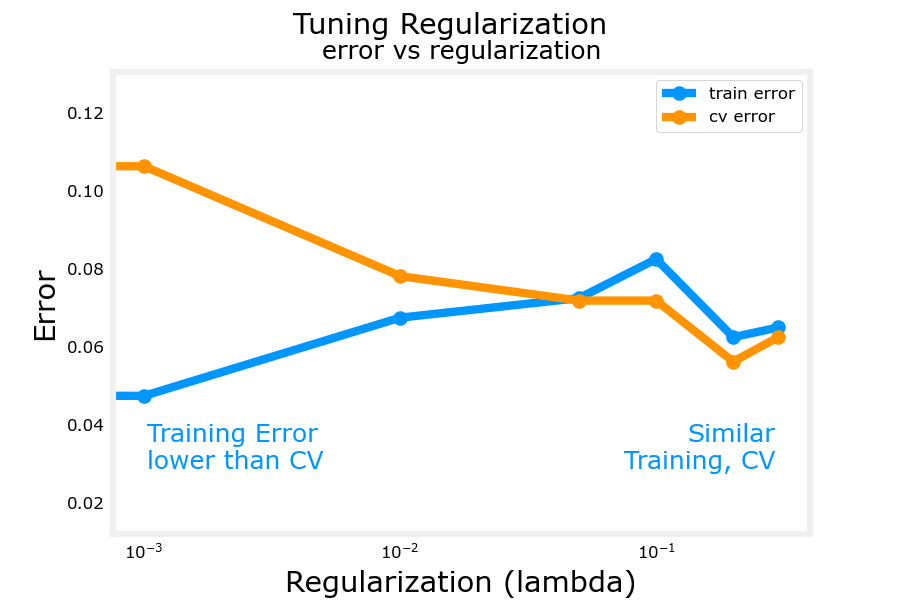

In [63]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

<IPython.core.display.Javascript object>


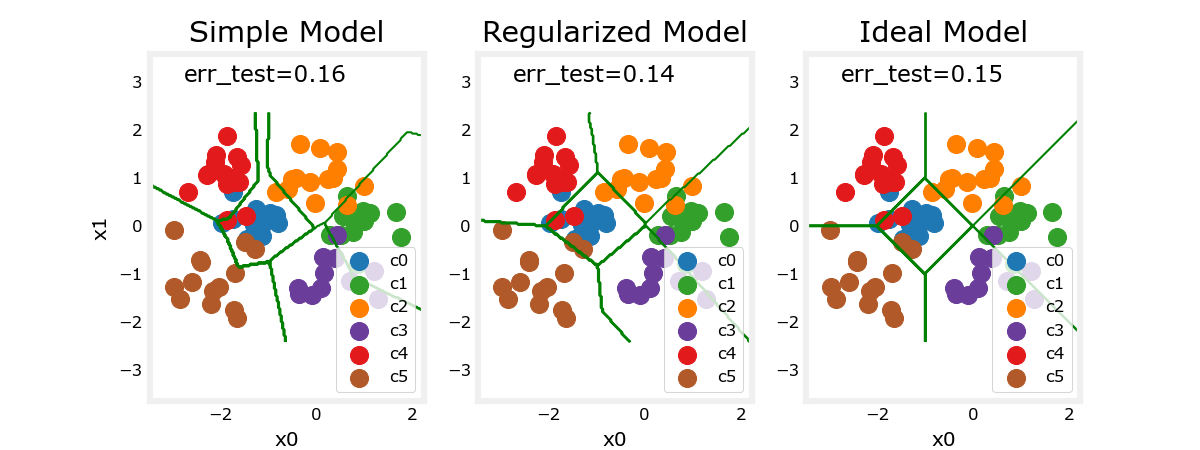

In [64]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>